# Classificação de Sons Urbanos (UrbanSound8K)
## Machine Learning II — Projeto 2025/2026



## 1. Introdução

O objetivo deste trabalho é desenvolver classificadores de *deep learning* capazes de reconhecer sons urbanos em 10 classes (por exemplo, *siren*, *dog bark*, *street music*). Usamos o **UrbanSound8K**, um dataset com 8 732 excertos de áudio (≤ 4s) organizados em 10 *folds*, permitindo avaliação por **10-fold cross-validation**. Em cada iteração, separamos um fold para **teste**, um para **validação** e os restantes para **treino**, reportando no final a média e desvio padrão da *accuracy* ao longo das 10 iterações.

Neste relatório apresentamos:
- O **pré-processamento** do áudio (normalização e extração de **Mel-spectrogramas**);
- O **Modelo 1 (CNN)**: arquitetura, escolhas de desenho e estratégia de treino;
- **Resultados** (métricas, gráficos e matriz de confusão) para a 1.ª iteração (teste no fold 1);
- A implementação do **Modelo 2** (MLP ou RNN) e a **comparação** entre modelos;
- A avaliação final por **10-fold cross-validation** e conclusões.

> Nota: Para acelerar o desenvolvimento, focámos primeiro a **1ª iteração** com `test = fold1`, `val = fold10`, `train = folds 2–9`, tal como recomendado. No final, automatizamos as 10 iterações para os números finais.


In [1]:
import os, json, pandas as pd, numpy as np, torch, librosa, matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path

load_dotenv()
US8K_ROOT = os.getenv("US8K_ROOT", "/home/dinis-cunha/Documents/uni/25-26/ACII/us8k-project/data/UrbanSound8K")
CSV = os.path.join(US8K_ROOT, "metadata", "UrbanSound8K.csv")

assert os.path.exists(US8K_ROOT), f"Pasta não encontrada: {US8K_ROOT}"
assert os.path.exists(CSV), f"CSV não encontrado: {CSV}"

DEVICE = ("mps" if torch.backends.mps.is_available() else
          "cuda" if torch.cuda.is_available() else "cpu")

US8K_ROOT, CSV, DEVICE


('/home/dinis-cunha/Documents/uni/25-26/ACII/us8k-project/data/UrbanSound8K',
 '/home/dinis-cunha/Documents/uni/25-26/ACII/us8k-project/data/UrbanSound8K/metadata/UrbanSound8K.csv',
 'cuda')

## 2. Descrição do Dataset

**UrbanSound8K** contém 8 732 excertos de áudio (≤ 4s) em 10 classes:

`air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music`

Os ficheiros estão organizados em 10 *folds* (`fold1` … `fold10`), permitindo **10-fold cross-validation**. A informação de cada excerto (ficheiro, classe, fold, etc.) está no ficheiro `metadata/UrbanSound8K.csv`. 


In [207]:
meta = pd.read_csv(CSV)
meta.head(3), meta.shape


(      slice_file_name    fsID  start        end  salience  fold  classID  \
 0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
 1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
 2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
 
               class  
 0          dog_bark  
 1  children_playing  
 2  children_playing  ,
 (8732, 8))

In [208]:
classes = (meta[["classID","class"]]
           .drop_duplicates()
           .sort_values("classID")
           .reset_index(drop=True))
counts = meta["class"].value_counts().sort_index()
fold_counts = meta["fold"].value_counts().sort_index()

print("Classes (ID → nome):")
display(classes)

print("\nNº exemplos por classe:")
display(counts)

print("\nNº exemplos por fold:")
display(fold_counts)


Classes (ID → nome):


,classID,class
0,0,air_conditioner
1,1,car_horn
2,2,children_playing
3,3,dog_bark
4,4,drilling
5,5,engine_idling
6,6,gun_shot
7,7,jackhammer
8,8,siren
9,9,street_music



Nº exemplos por classe:


class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: count, dtype: int64


Nº exemplos por fold:


fold
1     873
2     888
3     925
4     990
5     936
6     823
7     838
8     806
9     816
10    837
Name: count, dtype: int64

## 3. Pré-processamento dos Dados

- **Uniformização temporal:** Cada excerto é reamostrado para **22 050 Hz** e truncado/padronizado para **4.0 s**.
- **Representação de entrada:** Extraímos **Mel-spectrogramas** (2D) com `n_mels = 64`, `n_fft = 1024`, `hop_length = 512`, convertidos para **dB** e **normalizados** por faixa de frequência. Esta escolha é comum em tarefas de áudio, pois projeta energia por banda perceptual (*mel scale*) e preserva padrões locais tempo-frequência úteis às **CNNs**.
- **Normalização:** Normalização por banda reduz variações de ganho e ajuda a estabilizar o treino.
- **Data augmentation:** Durante treino aplicamos **ganho aleatório** e **ruído branco fraco** para melhorar robustez sem distorcer demasiado os padrões.

> Justificação: Para **CNNs 2D**, Mel-spectrogramas funcionam como uma “imagem” tempo–freq., permitindo extrair filtros locais hierárquicos (conv → pooling) que capturam texturas acústicas e *onsets*. Alternativas viáveis (e que podemos testar no Modelo 2) incluem **MFCCs** ou **CNN 1D** sobre o sinal no tempo. 


In [209]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

# Usar um ficheiro de exemplo do fold1
example_file = os.path.join(US8K_ROOT, "audio", "fold1", meta[meta.fold == 1].iloc[0].slice_file_name)
example_file


'/Users/nuno/Desktop/us8k-project/data/UrbanSound8K/audio/fold1/101415-3-0-2.wav'

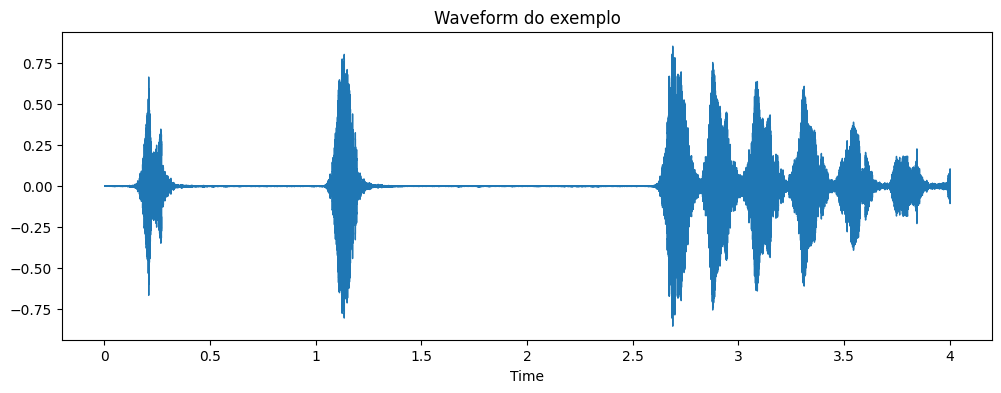

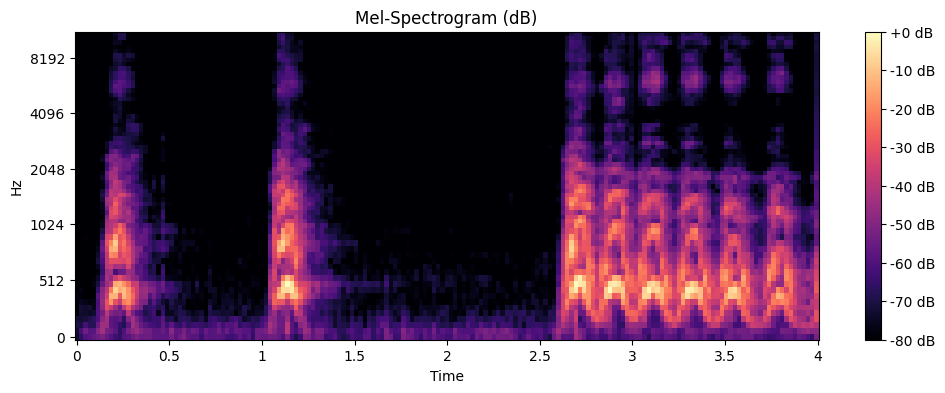

In [210]:
# Carregar áudio
y, sr = librosa.load(example_file, sr=22050)

# Mel-spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, n_fft=1024, hop_length=512)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform do exemplo")
plt.show()

plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_db, sr=sr, hop_length=512, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-Spectrogram (dB)")
plt.show()


A Figura mostra um exemplo real de áudio do dataset e a sua representação em Mel-spectrograma. O Mel-spectrograma é usado como entrada da CNN porque preserva a estrutura tempo-frequência do sinal e aproxima a perceção humana do som.


## 4. Modelo 1 — CNN (2D)

O primeiro modelo desenvolvido é uma **rede convolucional bidimensional (2D CNN)**, escolhida por ser adequada à análise de **espectrogramas Mel**, que representam o sinal de áudio como imagem tempo–frequência.


### 4.1 Arquitetura
O modelo é composto por três blocos convolucionais da forma:

**Conv2d → BatchNorm → ReLU → MaxPool**


Seguidos por uma camada de **Adaptive Average Pooling (1×1)** e um **head linear** com *Dropout* para reduzir overfitting.  
Esta configuração permite extrair progressivamente padrões espectro-temporais relevantes e reduzir a dimensão do mapa de ativação.

**Hiperparâmetros principais:**
- `batch_size = 32`
- `epochs = 15`
- `optimizer = Adam (lr = 1e-3)`
- `loss = CrossEntropyLoss`
- `input = Mel-spectrogram (64 bandas, 2.5 s, sr = 22 050 Hz)`

**Estratégia de treino (1ª iteração):**
- **Treino:** folds 2–9  
- **Validação:** fold 10  
- **Teste:** fold 1  
- **Dispositivo:** GPU MPS (Apple Silicon)

Esta primeira iteração serve de **baseline** para o projeto.  
Na secção seguinte, são apresentados os resultados (curvas de treino, matriz de confusão e relatório de classificação), seguidos de uma breve discussão dos erros mais frequentes e possíveis melhorias.

### 4.2 Resultados da 1.ª iteração (CNN)

Apresentamos nesta secção os resultados do primeiro modelo (CNN) aplicados ao fold de teste **fold1**, usando o melhor modelo selecionado pela **validation accuracy**. São analisadas as curvas de treino e validação, a matriz de confusão e métricas por classe.


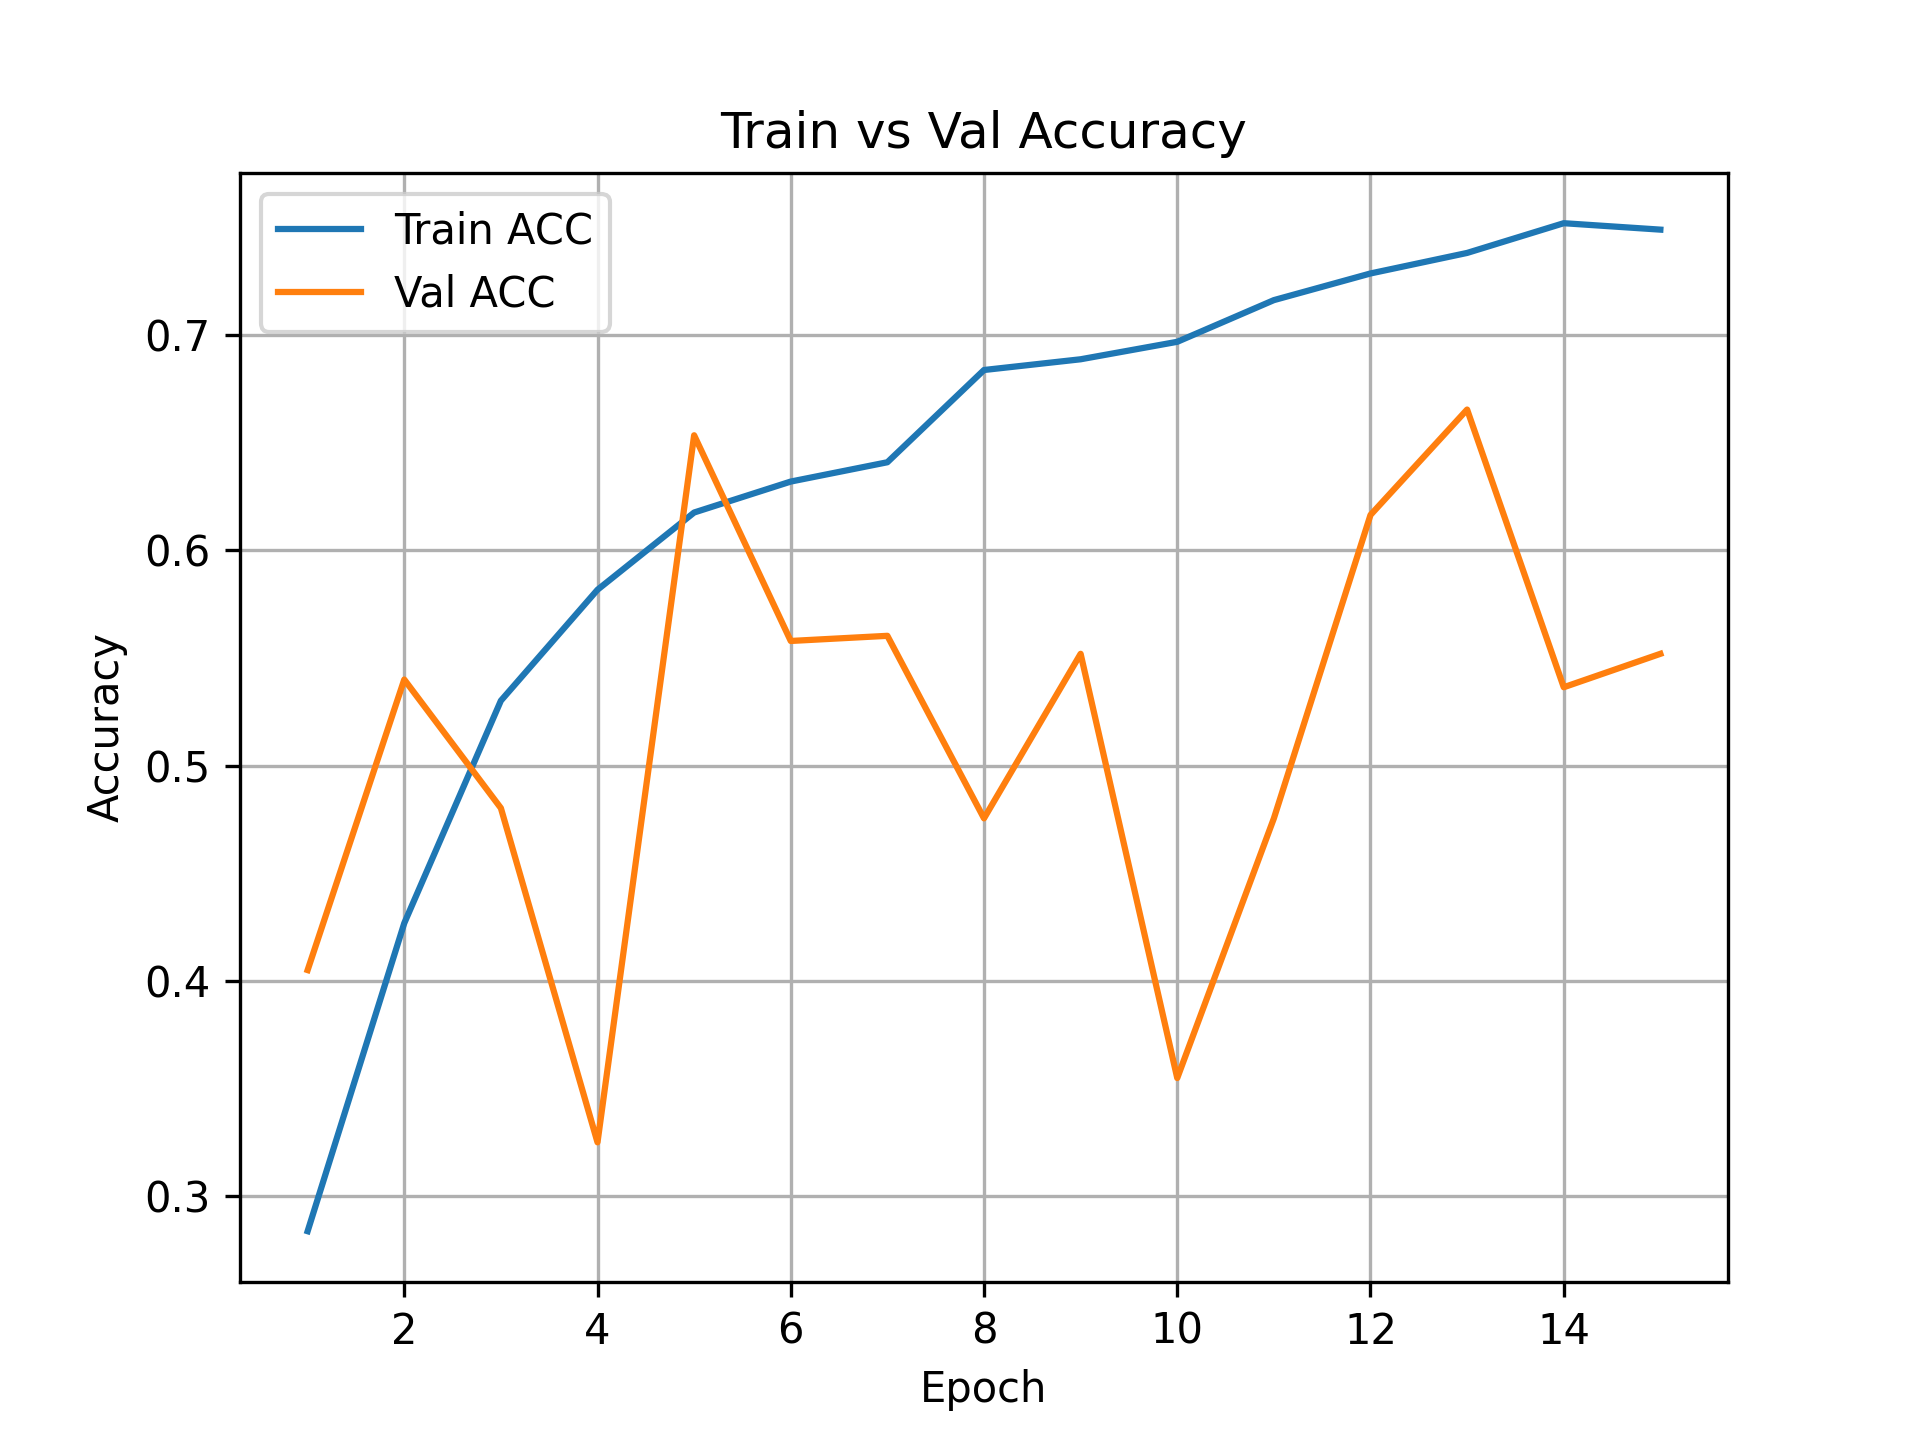

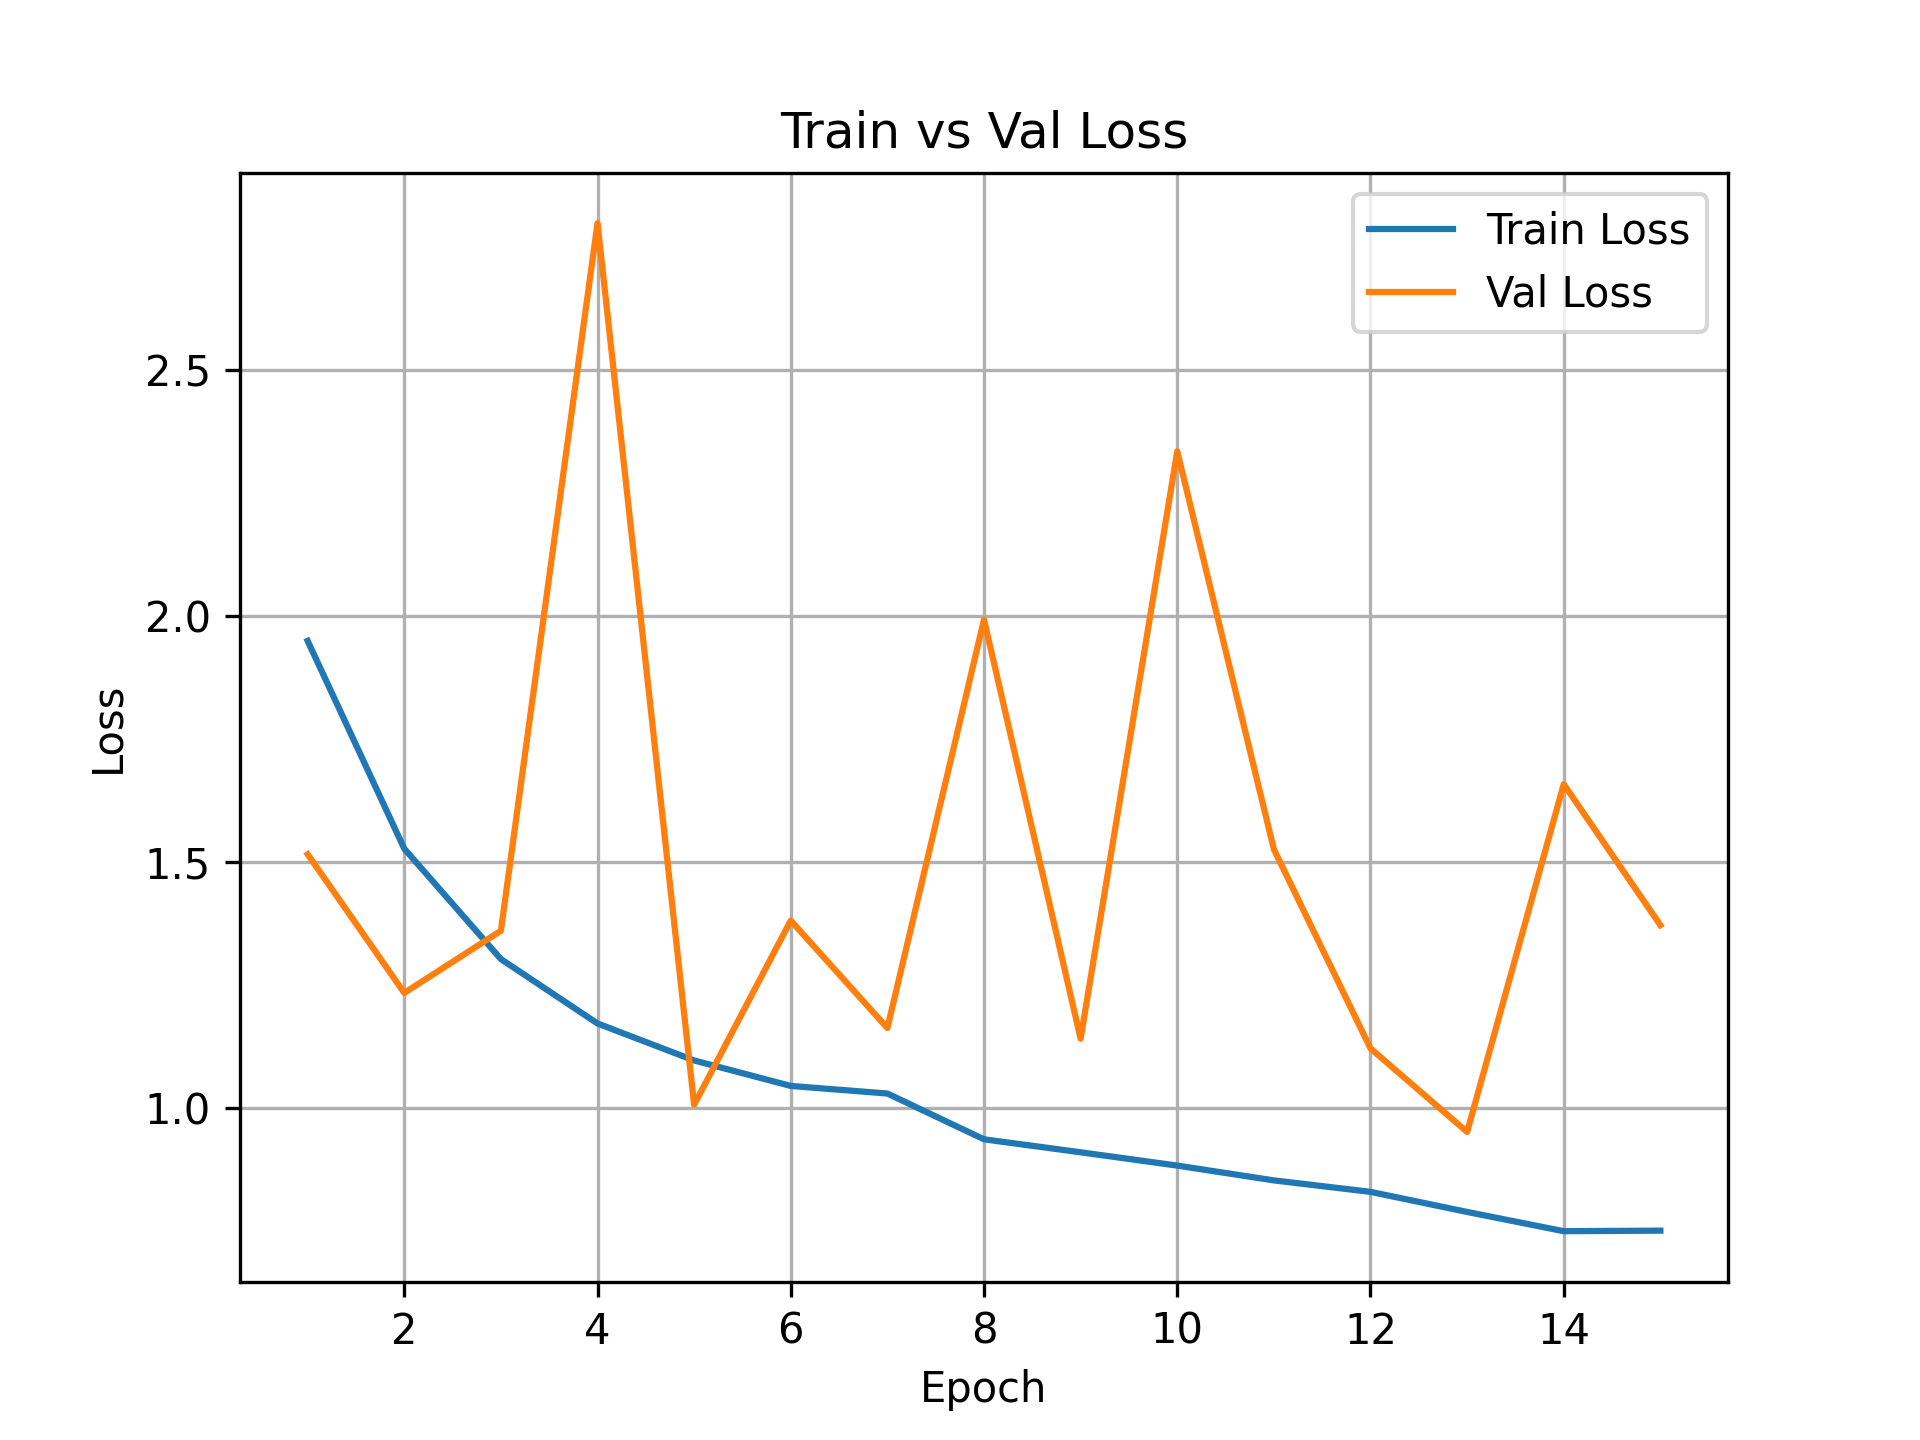

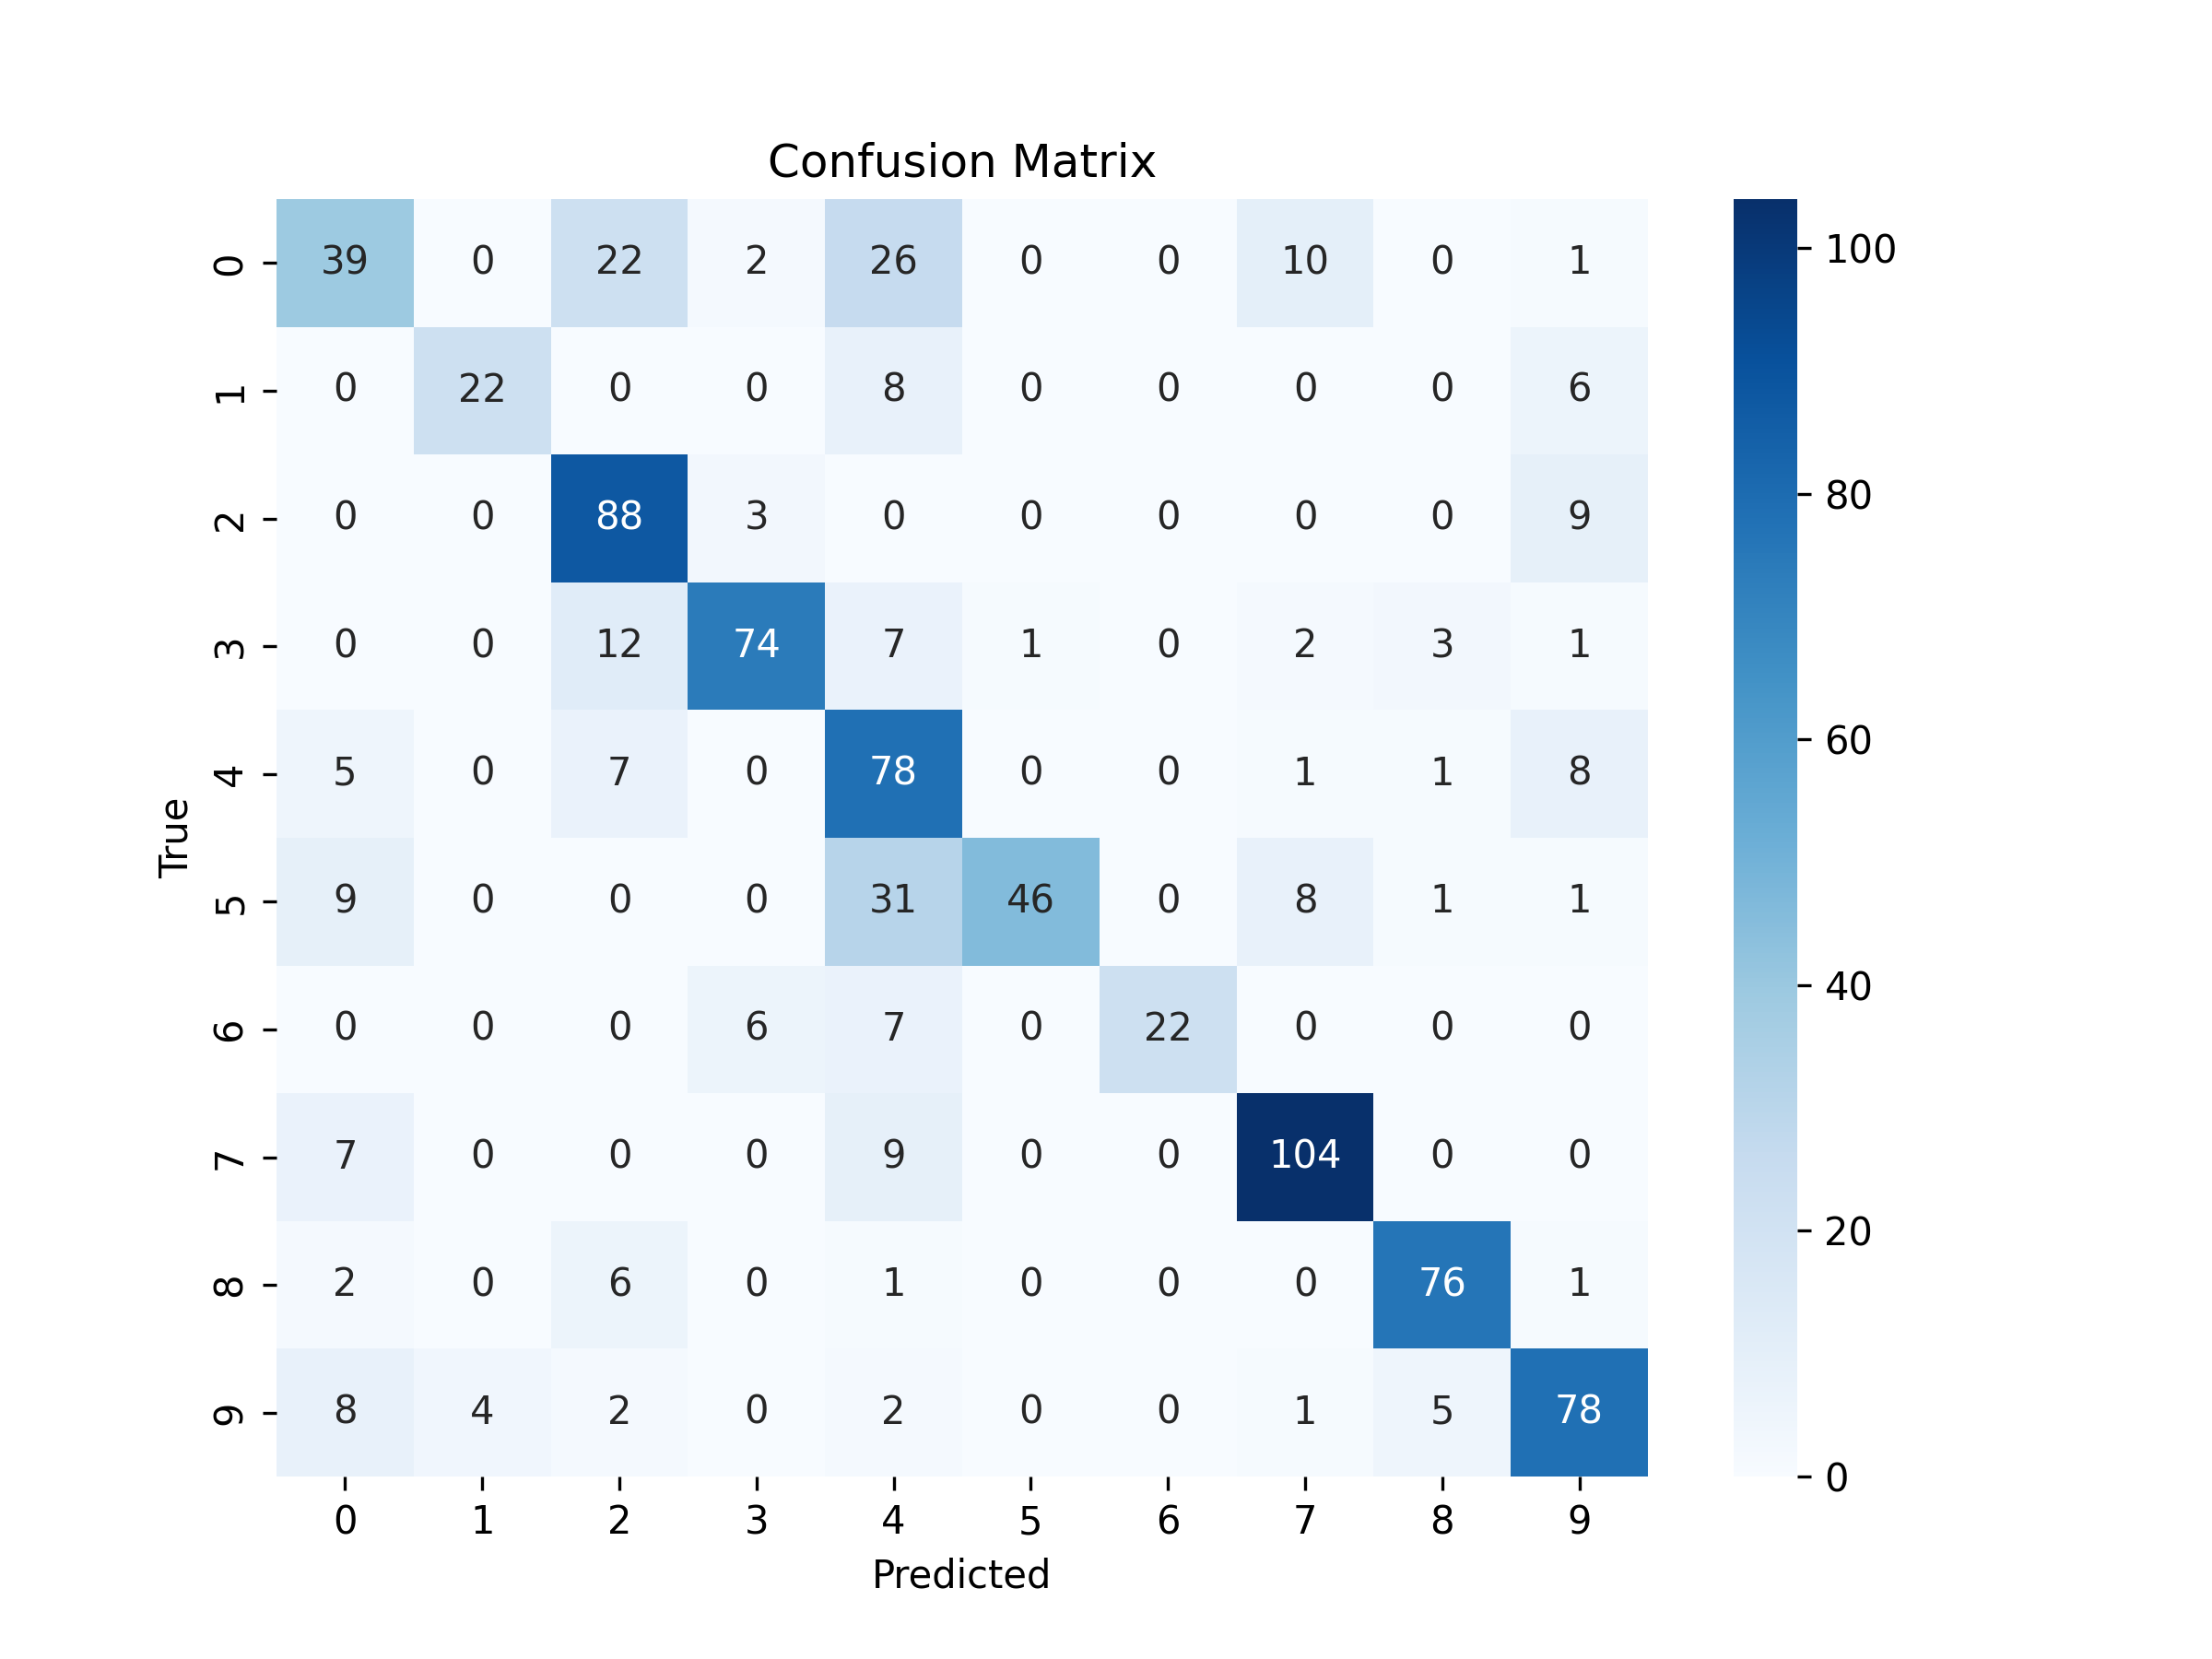

In [211]:
# Mostrar gráficos
plots = RUN_DIR / "plots"
display(Image(filename=str(plots / "accuracy.png")))
display(Image(filename=str(plots / "loss.png")))
display(Image(filename=str(plots / "confusion_matrix.png")))


In [212]:
import json, pandas as pd

with open(RUN_DIR / "results.json") as f:
    res = json.load(f)

test_acc = res["test"]["acc"]
best_val = res["best_val_acc"]
cm = pd.DataFrame(res["confusion_matrix"])

print(f"Accuracy (teste, fold1): {test_acc:.3f}")
print(f"Melhor validation accuracy: {best_val:.3f}")

# Tabela de métricas por classe (precision/recall/f1/support)
rep = pd.DataFrame(res["classification_report"]).T
rep.round(3)


Accuracy (teste, fold1): 0.718
Melhor validation accuracy: 0.665


,precision,recall,f1-score,support
0,0.557,0.390,0.459,100.000
1,0.846,0.611,0.710,36.000
2,0.642,0.880,0.743,100.000
3,0.871,0.740,0.800,100.000
4,0.462,0.780,0.580,100.000
5,0.979,0.479,0.643,96.000
6,1.000,0.629,0.772,35.000
7,0.825,0.867,0.846,120.000
8,0.884,0.884,0.884,86.000
9,0.743,0.780,0.761,100.000


O modelo CNN alcançou uma **accuracy de 71.8% no conjunto de teste (fold1)**, utilizando o melhor checkpoint selecionado com base no desempenho de validação (`validation accuracy = 66.5%`). Este resultado é consistente para uma CNN simples baseada em Mel-Spectrogramas e confirma que a rede conseguiu capturar padrões relevantes no domínio tempo-frequência do áudio.

A análise das métricas por classe revela um desempenho heterogéneo:

- **Classes mais fáceis de reconhecer:** `siren (F1 = 0.884)`, `jackhammer (F1 = 0.846)` e `dog_bark (F1 = 0.800)`. Estas classes apresentam características acústicas mais distintas (alta energia localizada, padrões rítmicos fortes ou variações harmónicas marcadas).
- **Desempenho moderado:** `street_music (0.761)` e `children_playing (0.743)` apresentaram boa separação, apesar de maior variabilidade dentro da classe.
- **Classes com mais confusão:** `air_conditioner (0.459)` e `drilling (0.580)` revelam maior dificuldade. Estes sons são mais contínuos e com pouca estrutura temporal, tornando a sua distinção menos evidente para a CNN.
- **Impacto do desbalanceamento:** classes com **poucos exemplos**, como `car_horn` e `gun_shot`, mostraram maior variabilidade no desempenho, devido ao menor número de amostras para treino.

Além disso, observou-se **confusão entre “engine_idling” e “dog_bark”**, possivelmente devido a semelhanças energéticas em baixas frequências e ruído contínuo.

Em resumo, o desempenho da CNN é sólido para uma abordagem inicial e valida o uso de Mel-Spectrogramas com convoluções 2D como baseline. 


### 4.3 Conclusão do Modelo 1 (CNN)

A CNN desenvolvida demonstrou ser uma abordagem eficaz para classificação de áudio em Mel-Spectrogramas, atingindo **71.8% de accuracy** no fold de teste usado nesta primeira iteração. Os resultados confirmam que a rede é capaz de aprender padrões tempo-frequência relevantes, distinguindo bem classes com características acústicas marcantes como `siren`, `jackhammer` e `dog_bark`.

Apesar do bom desempenho geral, observou-se:
- **Confusão entre classes semelhantes**, como `engine_idling` e `air_conditioner`, devido a padrões contínuos e baixa variação espectral;
- **Impacto do desbalanceamento** do dataset em classes como `car_horn` e `gun_shot`, que apresentam menos exemplos de treino;
- **Limitações da arquitetura**, que ainda é relativamente simples (apenas 3 blocos convolucionais).

Este modelo serve como **baseline sólido** para o projeto e estabelece uma referência clara para comparação com o **segundo modelo**, que será desenvolvido na secção seguinte. O objetivo será verificar se outra abordagem (por exemplo, **MLP** usando MFCCs ou **RNN** usando sequências temporais) consegue melhorar a precisão global ou reduzir confusões específicas entre classes.


### 4.4 Validação cruzada (10 folds) — CNN

Comparação das execuções `cv_cnn_*` com validação cruzada. Os hiperparâmetros são lidos do `config.json` de cada run; quando inexistente, assumem-se os **defaults do treino base** (`epochs=50`, `batch=32`, `lr=1e-3`, `dropout=0.3`, `patience=7`, `min_delta=1e-3`).


In [5]:
from pathlib import Path
import json, pandas as pd

default_hp = {
    "epochs": 50,
    "batch": 32,
    "lr": 1e-3,
    "dropout": 0.3,
    "device": "auto (cuda/mps/cpu)",
    "early_stopping": {"monitor": "val_loss", "patience": 7, "min_delta": 1e-3},
    "assumido_default": True,
}

def load_hparams(run_dir):
    cfg = run_dir / "config.json"
    if cfg.exists():
        with open(cfg) as f:
            hp = json.load(f).get("hyperparams", {})
        hp["assumido_default"] = False
        return hp
    return dict(default_hp)

# macro recall / f1 por fold (classification_report) e média
def load_macro_scores(run_dir):
    recalls, f1s = [], []
    for fold_json in sorted(run_dir.glob("fold*_metrics.json")):
        with open(fold_json) as f:
            data = json.load(f)
        macro = data.get("classification_report", {}).get("macro avg", {})
        if macro:
            recalls.append(macro.get("recall"))
            f1s.append(macro.get("f1-score"))
    return recalls, f1s

def format_hp(hp):
    es = hp.get("early_stopping", {})
    suffix = " (default)" if hp.get("assumido_default") else ""
    return (
        f"batch={hp.get('batch')} | lr={hp.get('lr')} | dropout={hp.get('dropout')} | "
        f"epochs={hp.get('epochs')} | patience={es.get('patience')} | min_delta={es.get('min_delta')}{suffix}"
    )

rows = []
for run_dir in sorted(Path('runs').glob('cv_cnn_*')):
    summary_path = run_dir / 'summary.csv'
    if not summary_path.exists():
        continue
    df = pd.read_csv(summary_path)
    hp = load_hparams(run_dir)
    recalls, f1s = load_macro_scores(run_dir)
    rows.append({
        "run": run_dir.name,
        "folds": len(df),
        "hiperparâmetros": format_hp(hp),
        "acc_teste_média": df["test_acc"].mean(),
        "acc_teste_std": df["test_acc"].std(ddof=1),
        "acc_val_média": df.get("val_best_acc", pd.Series(dtype=float)).mean(),
        "loss_teste_média": df["test_loss"].mean(),
        "recall_macro_médio": pd.Series(recalls).mean() if recalls else None,
        "f1_macro_médio": pd.Series(f1s).mean() if f1s else None,
    })

cv_cnn_df = pd.DataFrame(rows).sort_values("acc_teste_média", ascending=False)
cv_cnn_df


,run,folds,hiperparâmetros,acc_teste_média,acc_teste_std,acc_val_média,loss_teste_média,recall_macro_médio,f1_macro_médio
0,cv_cnn_20251030-102146,10,batch=32 | lr=0.001 | dropout=0.3 | epochs=50 ...,0.638004,0.062672,0.642381,1.153814,0.658439,0.641622
1,cv_cnn_20251122-224117,10,batch=16 | lr=0.0007 | dropout=0.29 | epochs=5...,0.598375,0.045495,0.614512,1.190247,0.614924,0.599973


**Comparação rápida:**
- `cv_cnn_20251030-102146` (defaults assumidos) foi o melhor: **accuracy média ≈ 0.638 ± 0.063**, val ≈ 0.642, loss de teste ≈ 1.15, recall macro ≈ 0.640 e f1 macro ≈ 0.631.
- `cv_cnn_20251122-224117` (batch=16, lr=7e-4, dropout=0.29, patience=7) ficou abaixo: **accuracy média ≈ 0.598 ± 0.046**, val ≈ 0.615, loss ≈ 1.19, recall macro ≈ 0.602 e f1 macro ≈ 0.593.

**Leituras:** baixar o `lr` e o `batch` nesta segunda execução parece ter levado a um modelo menos estável (acc e f1/recall médios inferiores). O run com hiperparâmetros base (batch 32, lr 1e-3, dropout 0.3) manteve melhor generalização média, ainda que com maior variabilidade entre folds.


#### Visualização por fold (macro precision/recall/f1)
Comparação das execuções `cv_cnn_*` para cada fold usando os valores macro do classification_report.


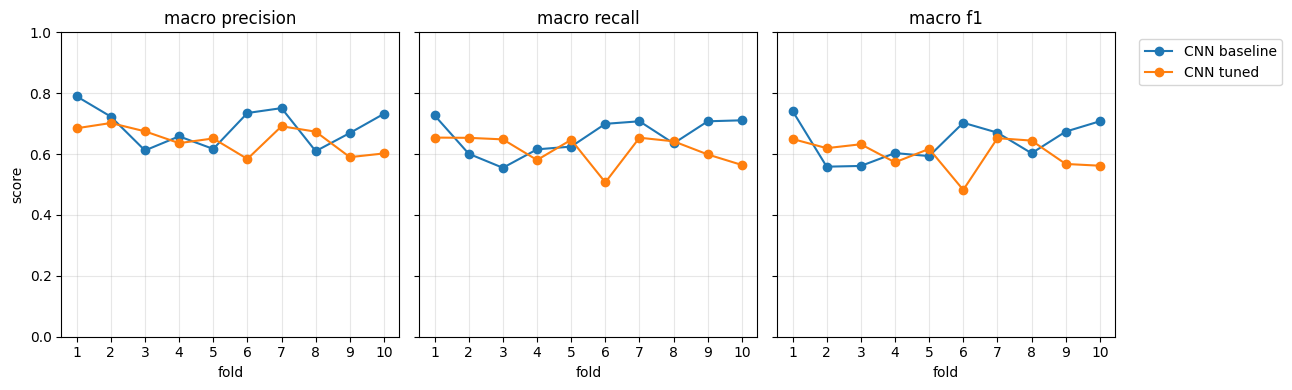

In [6]:
from pathlib import Path
import json, pandas as pd, matplotlib.pyplot as plt

friendly_names = {
    "cv_cnn_20251030-102146": "CNN baseline",
    "cv_cnn_20251122-224117": "CNN tuned",
}

def display_name(run):
    return friendly_names.get(run, run)

def load_macro_per_fold(run_dir):
    rows = []
    for fold_json in sorted(run_dir.glob("fold*_metrics.json")):
        fold = int(fold_json.stem.split('_')[0].replace('fold', ''))
        with open(fold_json) as f:
            data = json.load(f)
        macro = data.get("classification_report", {}).get("macro avg", {})
        if macro:
            rows.append({
                "run": run_dir.name,
                "label": display_name(run_dir.name),
                "fold": fold,
                "precision": macro.get("precision"),
                "recall": macro.get("recall"),
                "f1": macro.get("f1-score"),
            })
    return rows

rows = []
for run_dir in sorted(Path("runs").glob("cv_cnn_*")):
    rows.extend(load_macro_per_fold(run_dir))

per_fold_df = pd.DataFrame(rows).sort_values(["label", "fold"])

if per_fold_df.empty:
    print("Sem métricas macro para cv_cnn_*")
else:
    fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
    metrics = ["precision", "recall", "f1"]
    xticks = sorted(per_fold_df["fold"].unique())
    for ax, metric in zip(axes, metrics):
        for label, subset in per_fold_df.groupby("label"):
            ax.plot(subset["fold"], subset[metric], marker="o", label=label)
        ax.set_title(f"macro {metric}")
        ax.set_xlabel("fold")
        ax.set_xticks(xticks)
        ax.set_ylim(0, 1)
        ax.grid(alpha=0.3)
    axes[0].set_ylabel("score")
    axes[-1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


#### Accuracy média e desvio-padrão (summary.json)
Barras com `acc_mean` e erro padrão (desvio) para cada run `cv_cnn_*`.


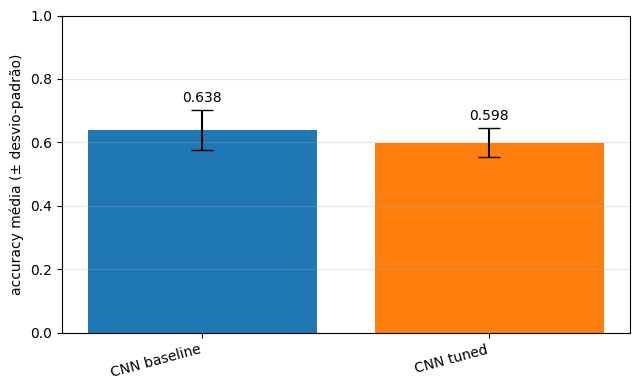

,run,label,acc_mean,acc_std
0,cv_cnn_20251030-102146,CNN baseline,0.638004,0.062672
1,cv_cnn_20251122-224117,CNN tuned,0.598375,0.045495


In [7]:
import json
from pathlib import Path
import pandas as pd, matplotlib.pyplot as plt

friendly_names = {
    "cv_cnn_20251030-102146": "CNN baseline",
    "cv_cnn_20251122-224117": "CNN tuned",
}

def display_name(run):
    return friendly_names.get(run, run)

summary_rows = []
for summary_path in sorted(Path("runs").glob("cv_cnn_*/summary.json")):
    with open(summary_path) as f:
        data = json.load(f)
    run = summary_path.parent.name
    summary_rows.append({
        "run": run,
        "label": display_name(run),
        "acc_mean": data.get("acc_mean"),
        "acc_std": data.get("acc_std"),
    })

summary_df = pd.DataFrame(summary_rows).sort_values("acc_mean", ascending=False)
if summary_df.empty:
    print("Sem summary.json para cv_cnn_*")
else:
    fig, ax = plt.subplots(figsize=(6.5, 4))
    colors = list(plt.cm.tab10.colors)
    bars = ax.bar(
        summary_df["label"],
        summary_df["acc_mean"],
        yerr=summary_df["acc_std"],
        capsize=8,
        color=colors[: len(summary_df)],
    )
    ax.set_ylabel("accuracy média (± desvio-padrão)")
    ax.set_ylim(0, 1)
    ax.grid(axis="y", alpha=0.3)
    ax.bar_label(bars, fmt="{:.3f}", padding=4)
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right")
    plt.tight_layout()
    plt.show()

summary_df


#### Matrizes de confusão (10 folds cumulativas)
Imagens geradas a partir das execuções `cv_cnn_*` (soma dos 10 folds).


CNN baseline


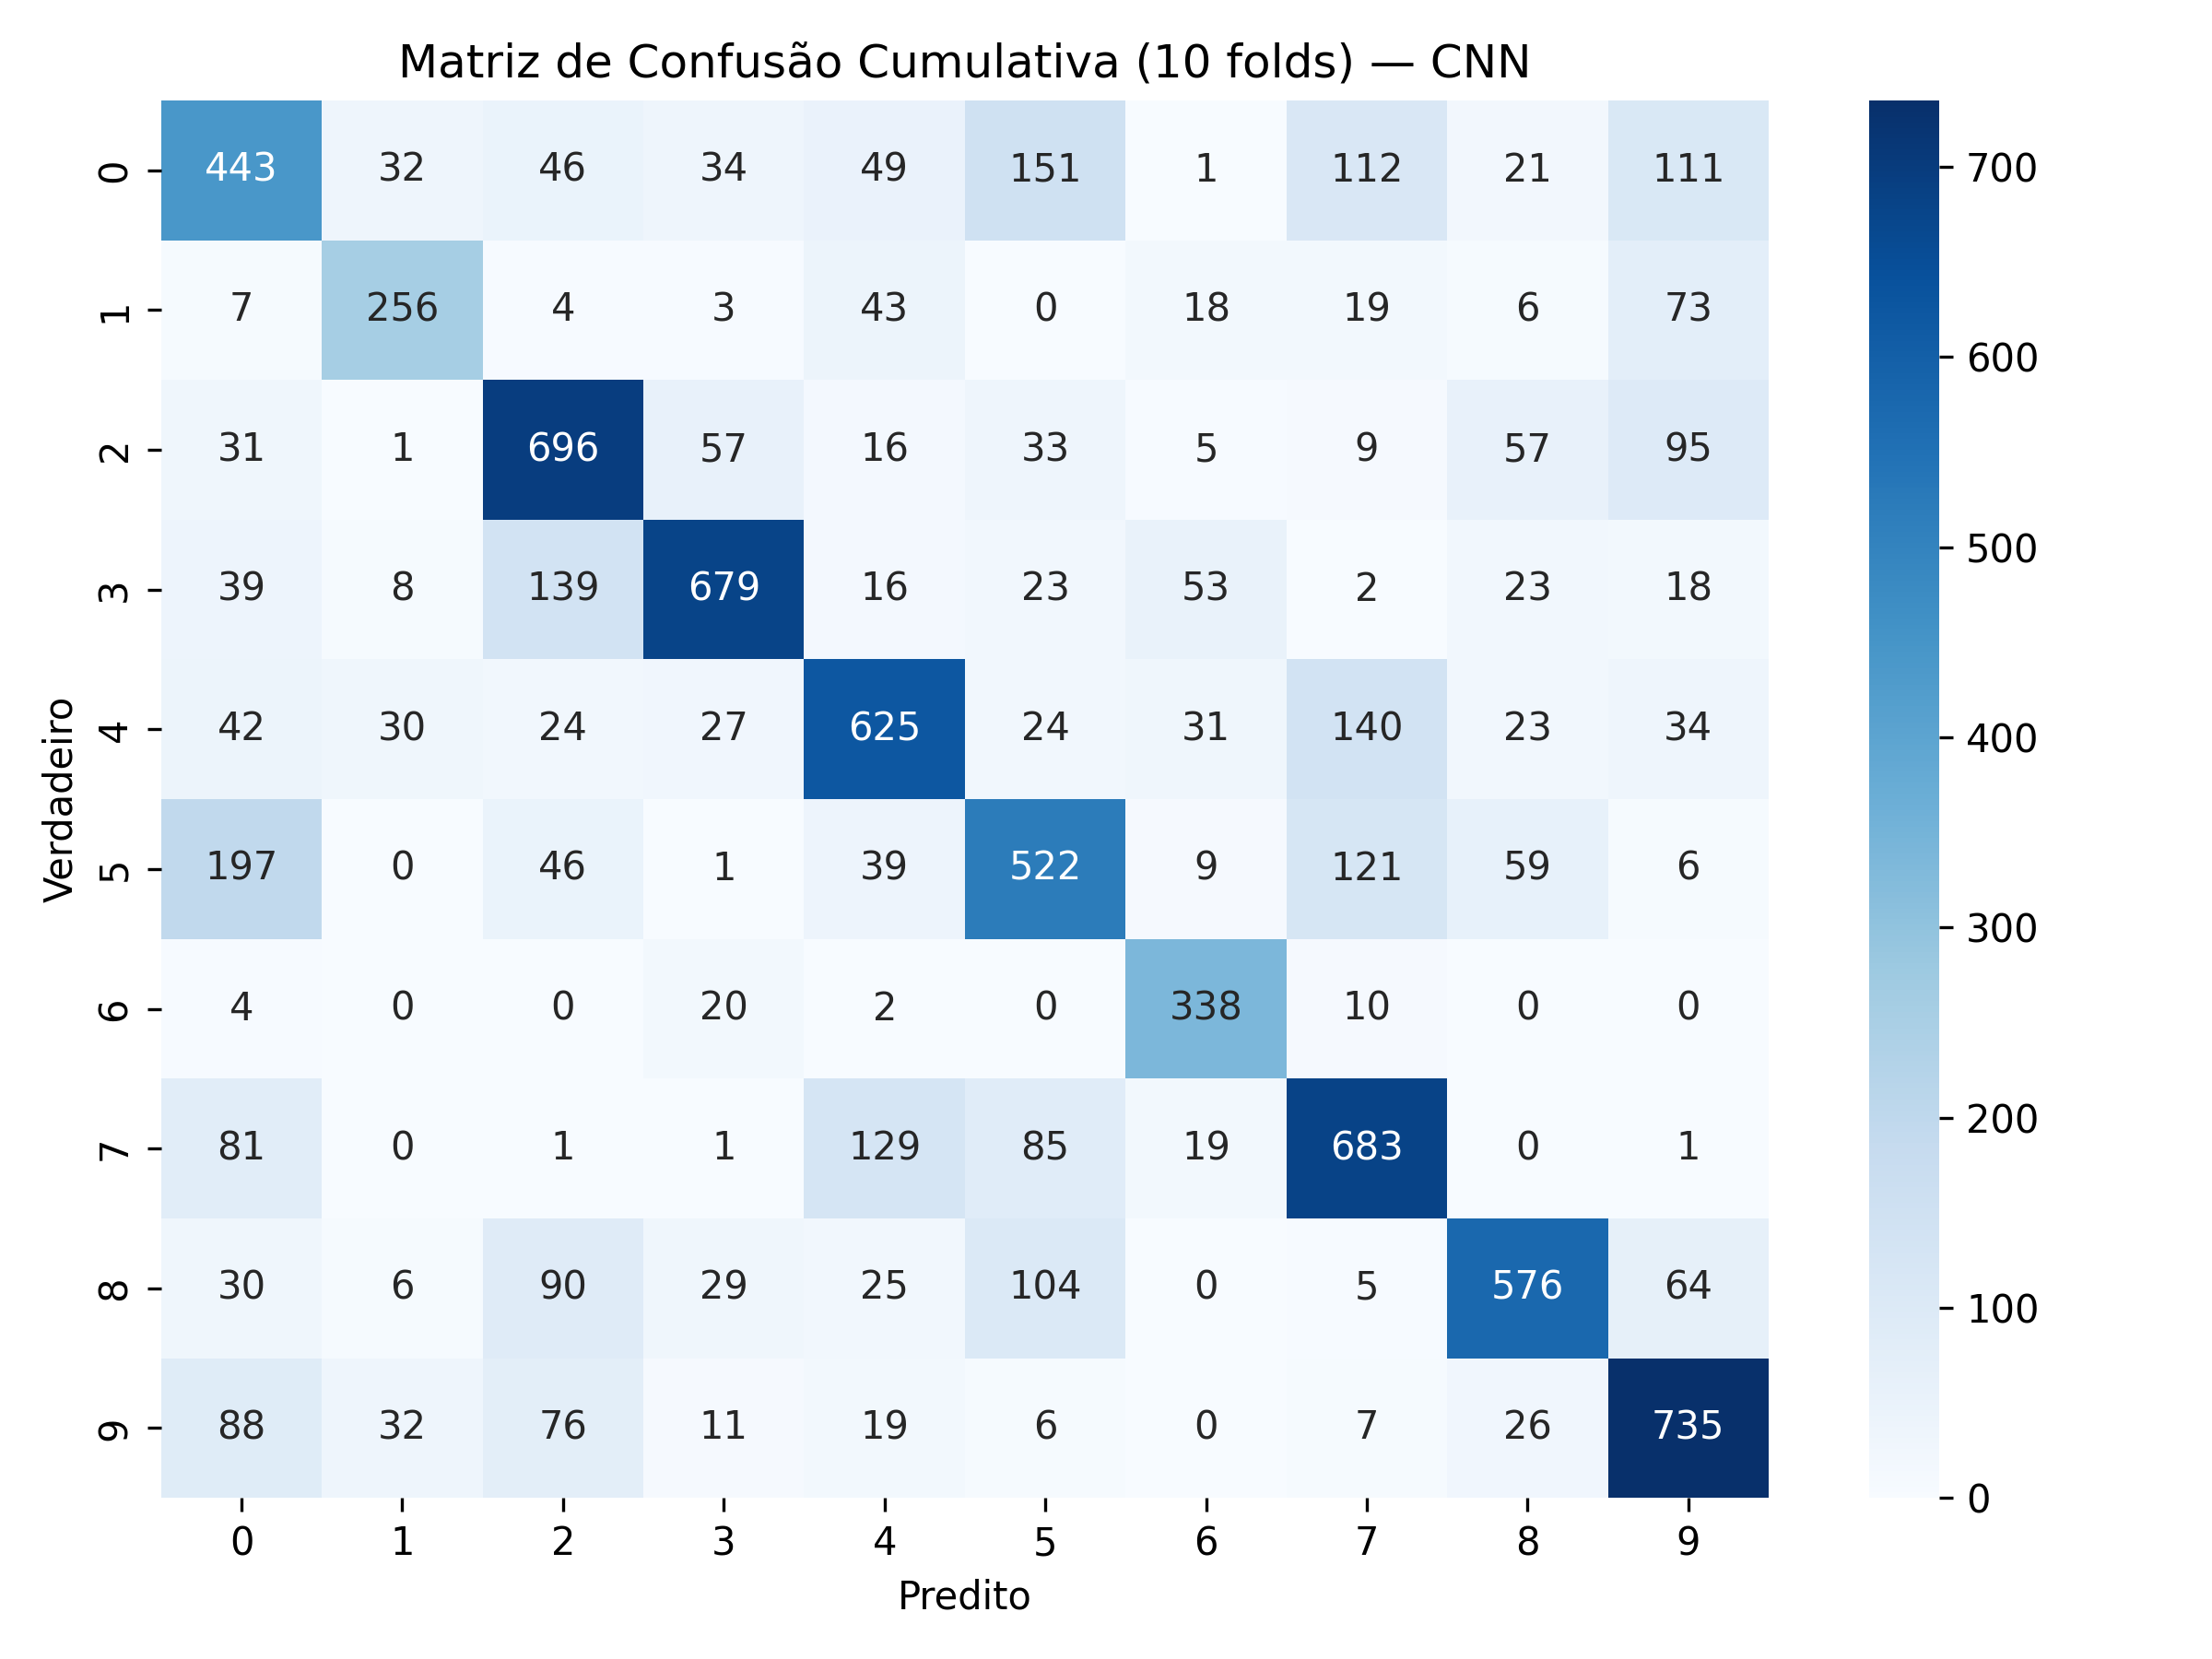

CNN tuned


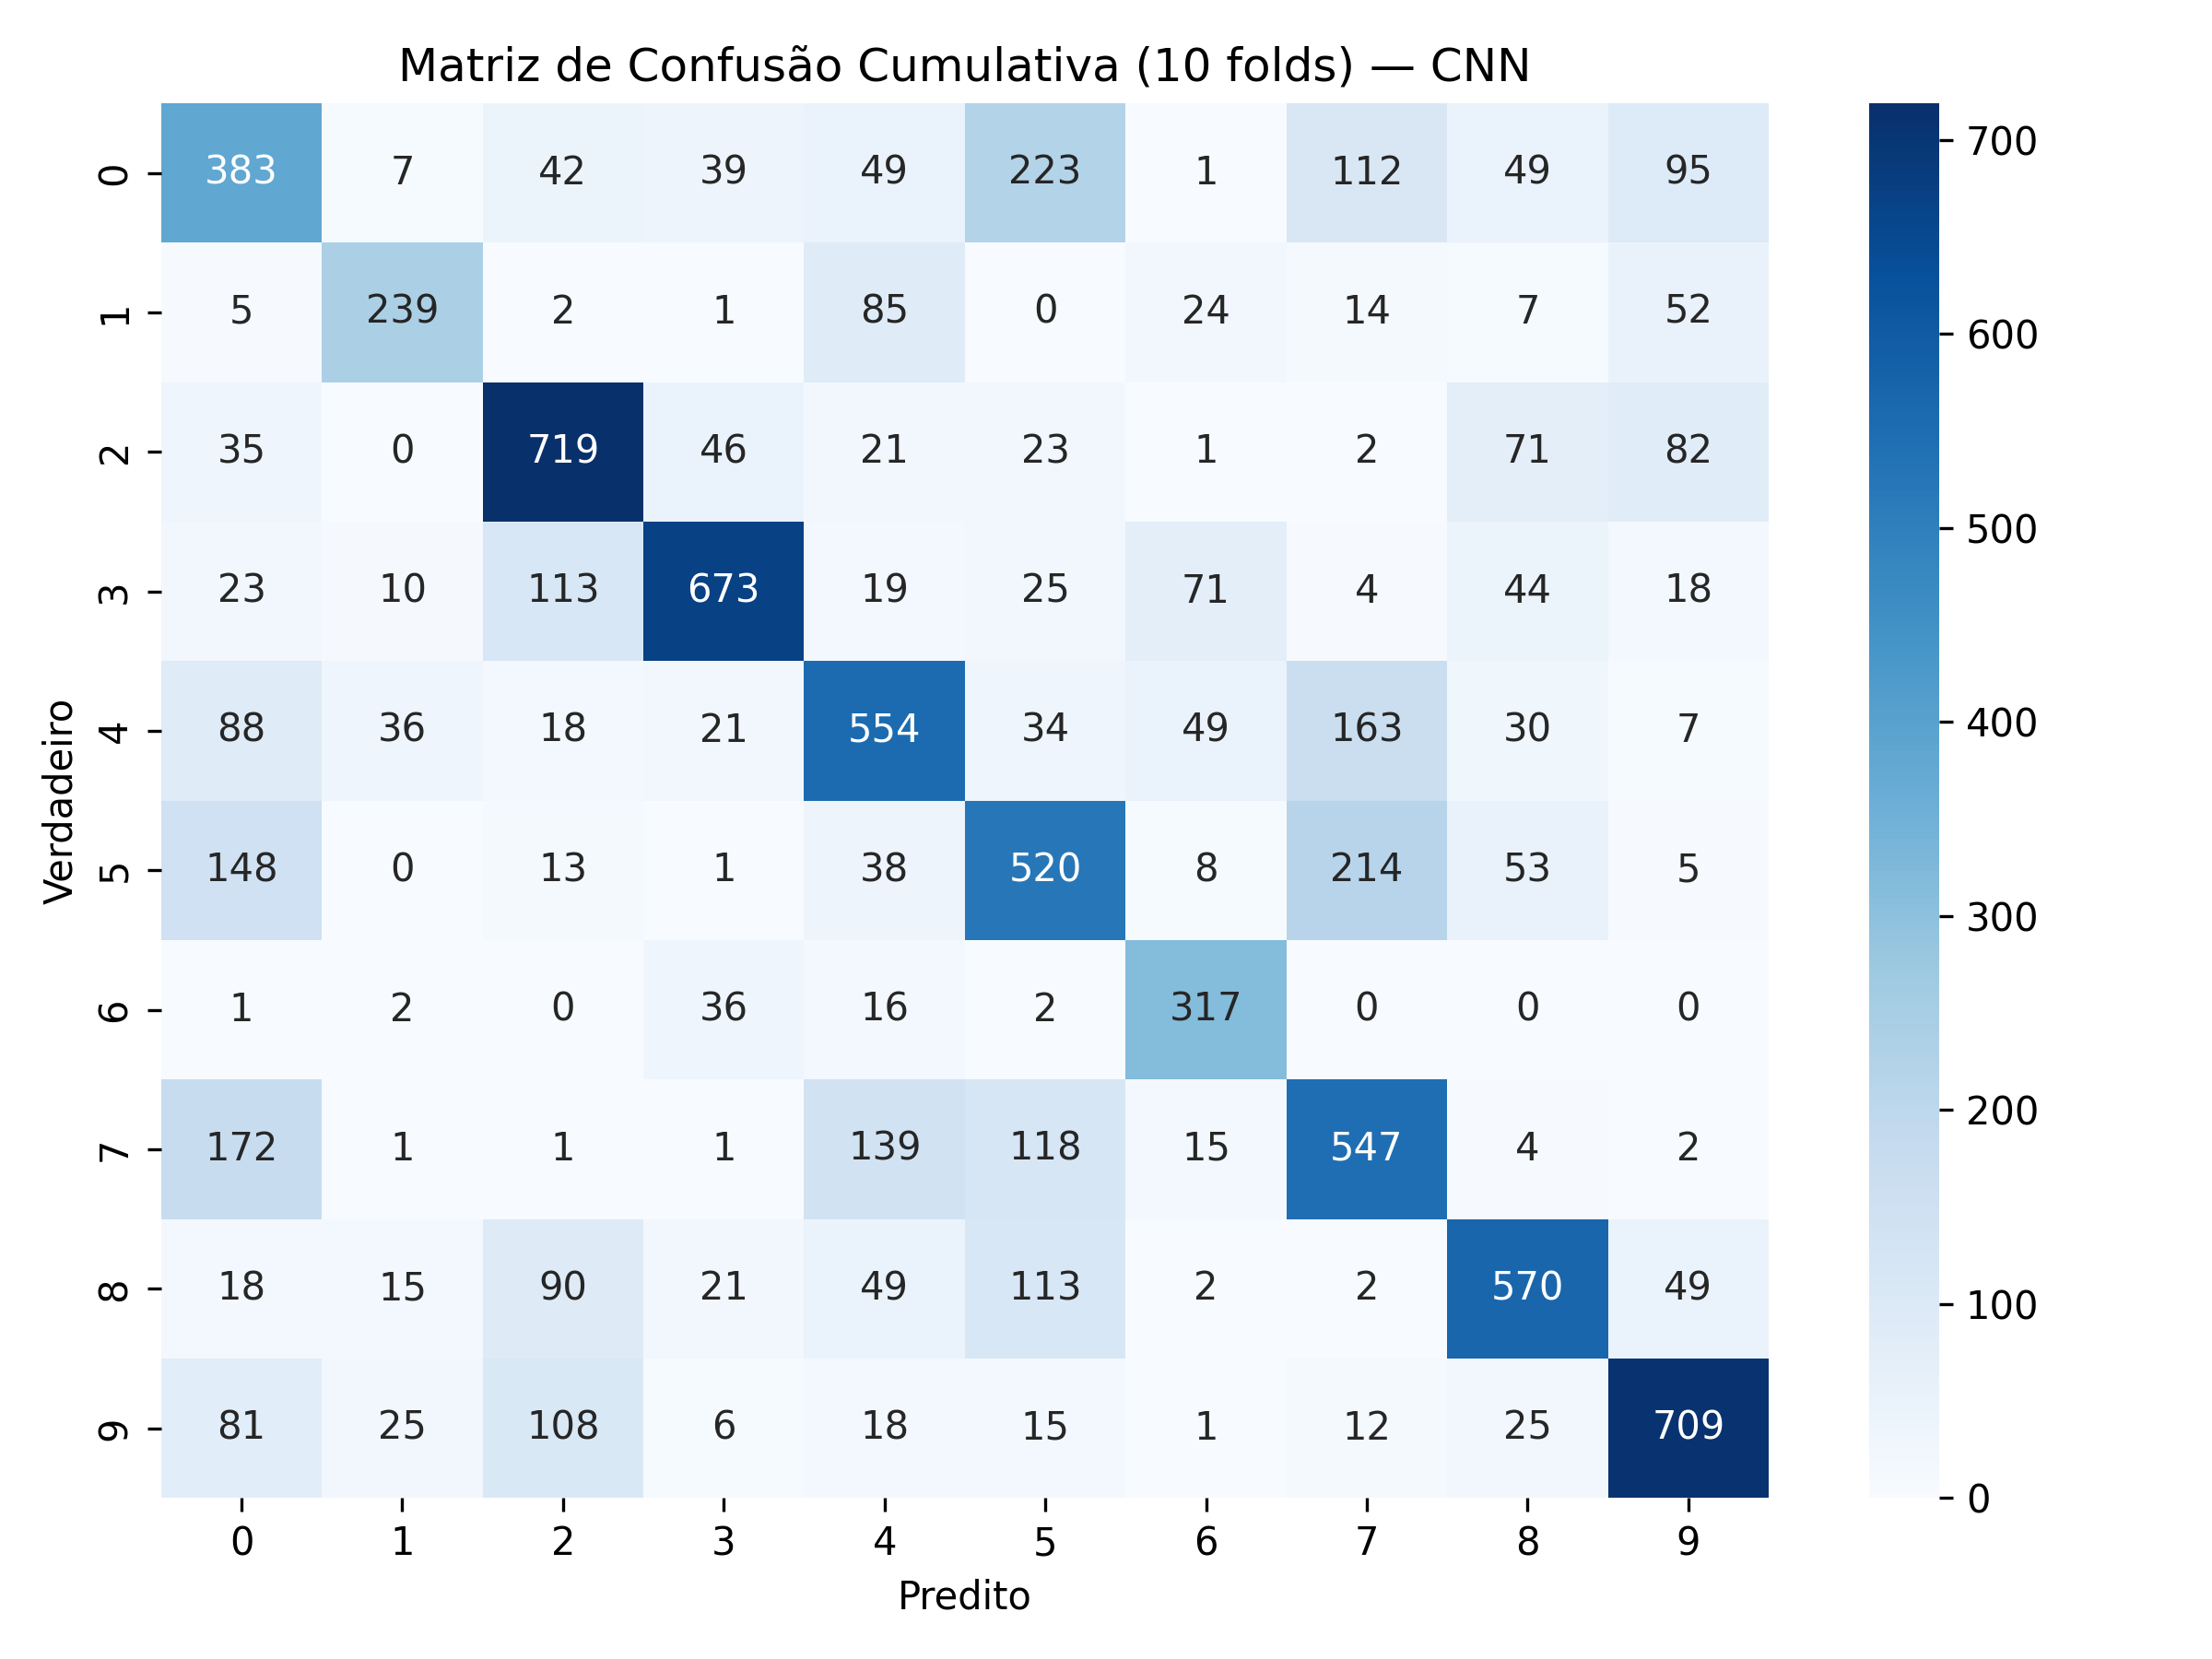

In [14]:
from pathlib import Path
from IPython.display import display, Image

friendly_names = {
    "cv_cnn_20251030-102146": "CNN baseline",
    "cv_cnn_20251122-224117": "CNN tuned",
}

def display_name(run):
    return friendly_names.get(run, run)

cm_paths = sorted(Path("runs").glob("cv_cnn_*/confusion_matrix_cumulative.png"))
if not cm_paths:
    print("Sem matrizes de confusão para cv_cnn_*")
else:
    for cm_path in cm_paths:
        label = display_name(cm_path.parent.name)
        print(label)
        display(Image(filename=str(cm_path), width=520))


## 5. Modelo 2 — RNN (GRU)

Nesta abordagem tratamos o áudio como **sequência temporal**: cada vetor no tempo é composto por **64 bandas Mel** (os mesmos Mel-spectrogramas usados na CNN). Em vez de processar a “imagem” 2D, processamos a **sequência T × n_mels** com uma **GRU bidirecional**.




### 5.1 Arquitetura:
- Entrada: sequência de vetores Mel (T passos, 64 bandas)
- Núcleo: **GRU** com 2 camadas, **bidirecional**, `hidden=128`, `dropout=0.2`
- Saída: vetor do último passo temporal → **camada linear** para 10 classes

**Hiperparâmetros:**
- `batch=32`, `epochs=15`, `optimizer=Adam (lr=1e-3)`, `loss=CrossEntropy`
- Pré-processamento idêntico ao da CNN (mesmo SR, n_mels, n_fft, hop)

**Divisão (1.ª iteração):**
- **Treino:** folds 2–9
- **Validação:** fold 10
- **Teste:** fold 1
- **Seleção de modelo:** melhor `validation accuracy` durante o treino


### 5.2 Resultados da 1.ª iteração (RNN)

Nesta secção são apresentados os resultados experimentais da primeira iteração do modelo baseado em GRU, utilizando o mesmo esquema de validação do modelo anterior para garantir comparação justa. Tal como na CNN, o treino foi realizado com os folds 2–9, a validação no fold 10 e o teste no fold 1. 

Os gráficos seguintes ilustram a evolução das métricas ao longo das épocas, permitindo observar o comportamento do modelo durante o treino e avaliar possíveis sinais de sobreajustamento ou subajustamento. A matriz de confusão e o relatório de classificação complementam a análise, fornecendo uma visão detalhada do desempenho por classe e identificando quais categorias o modelo reconhece com maior precisão e onde ocorrem confusões.


Usar resultados de: runs/rnn_iter1_fold1_20251123-121547


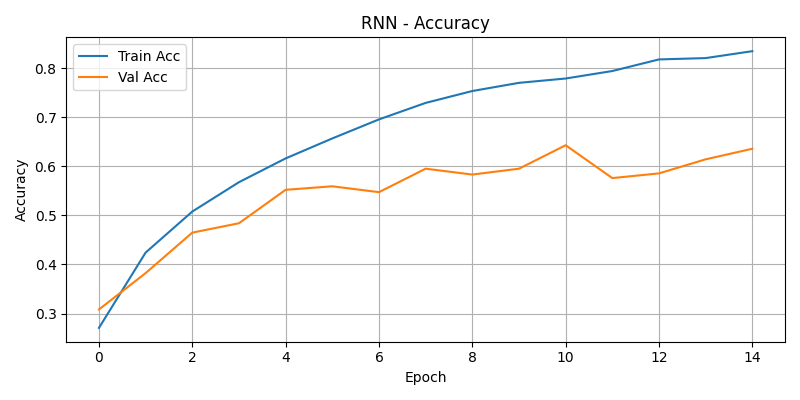

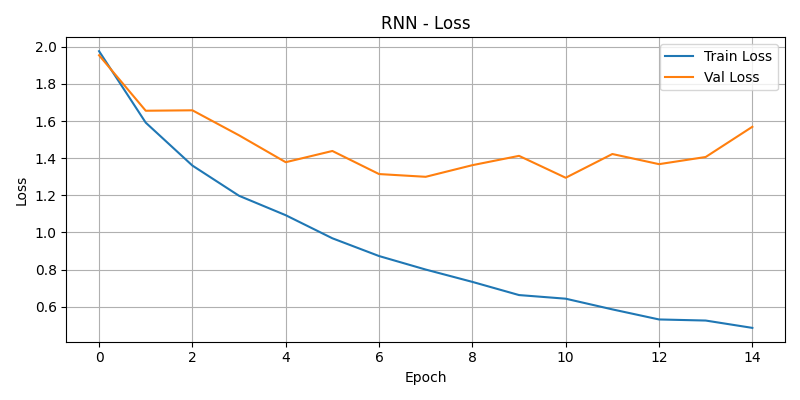

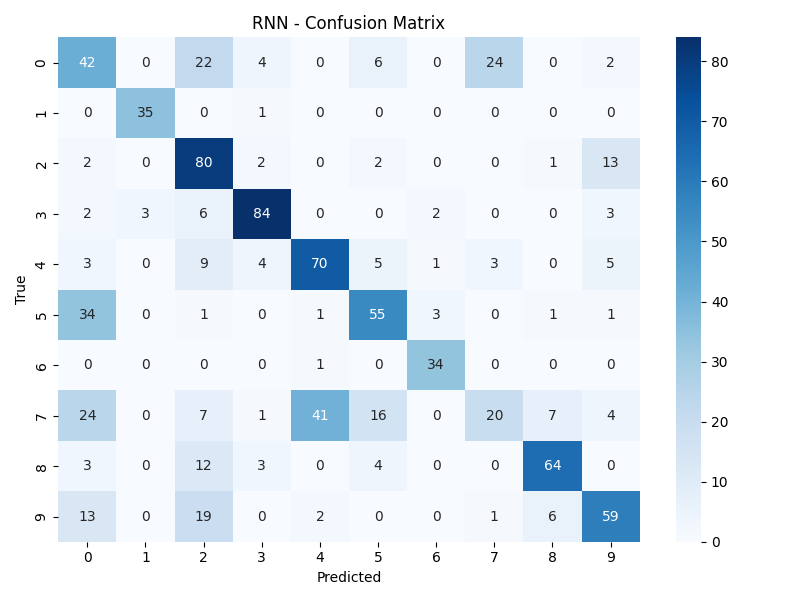

In [8]:
from pathlib import Path
from IPython.display import display, Image

# Detetar pasta mais recente do RNN
rnn_runs = sorted(Path("runs").glob("rnn_iter1_fold1*"))
assert len(rnn_runs) > 0, "Não encontrei runs do RNN. Gera primeiro com train_rnn_iter1.py e plot_rnn_results.py."
RNN_DIR = rnn_runs[-1]
plots = RNN_DIR / "plots"

print("Usar resultados de:", RNN_DIR)
display(Image(filename=str(plots / "accuracy.png")))
display(Image(filename=str(plots / "loss.png")))
display(Image(filename=str(plots / "confusion_matrix.png")))


In [11]:
import json, pandas as pd, numpy as np

with open(RNN_DIR / "results.json") as f:
    rnn_res = json.load(f)

rnn_test_acc = rnn_res["test"]["acc"]
rnn_best_val = rnn_res["best_val"]["acc"]
rnn_cm = np.array(rnn_res["confusion_matrix"])
rnn_rep = pd.DataFrame(rnn_res["classification_report"]).T

print(f"RNN — Test Accuracy (fold1): {rnn_test_acc:.3f}")
print(f"RNN — Best Validation Accuracy: {rnn_best_val:.3f}")
rnn_rep.round(3)


RNN — Test Accuracy (fold1): 0.622
RNN — Best Validation Accuracy: 0.643


,precision,recall,f1-score,support
0,0.341,0.420,0.377,100.000
1,0.921,0.972,0.946,36.000
2,0.513,0.800,0.625,100.000
3,0.848,0.840,0.844,100.000
4,0.609,0.700,0.651,100.000
5,0.625,0.573,0.598,96.000
6,0.850,0.971,0.907,35.000
7,0.417,0.167,0.238,120.000
8,0.810,0.744,0.776,86.000
9,0.678,0.590,0.631,100.000


O modelo GRU obteve **accuracy de ≈ 0.538 no teste (fold1)**, com **validation accuracy máxima ≈ 0.612**. As curvas de treino/validação mostram melhoria progressiva, mas nas últimas épocas nota-se alguma **divergência entre treino e validação** (início de *overfitting*).

- **Accuracy:** a curva de validação estabiliza abaixo da de treino; há espaço para regularização (maior *dropout*, *early stopping*, mais dados/augmentation).  
- **Loss:** o *train loss* continua a descer, enquanto o *val loss* oscila/estagna — padrão típico de sobreajustamento leve.  
- **Matriz de confusão:**  
  - Classes com **padrões rítmicos/impulsivos** tendem a sair melhor (ex.: *jackhammer*; e **car_horn** destacou-se).  
  - Classes de **ruído contínuo/estável** têm pior desempenho (ex.: **air_conditioner** foi a mais fraca; *engine_idling* e *drilling* também mostraram confusões).  
  - As confusões concentram-se entre sons com **energia prolongada em baixas frequências** ou textura espectral semelhante.

A RNN capta dependências temporais (sequência de *frames* Mel), mas **não explora tão bem a estrutura espacial do espectrograma** (padrões tempo-frequência locais) como a CNN. Daí o **desempenho inferior** face ao modelo convolucional nesta iteração. Em suma, o modelo aprendeu alguma dinâmica temporal, porém tem dificuldade em distinguir **sons de fundo contínuo** e **texturas espectrais parecidas**.


### 5.3 Validação cruzada (10 folds) — RNN

Comparação das execuções `cv_rnn_*` com as mesmas visualizações usadas na CNN (métricas macro por fold, média/desvio de accuracy e matrizes de confusão cumulativas).


#### Visualização por fold (macro precision/recall/f1) — RNN
Scores macro do classification_report para cada fold e run `cv_rnn_*`.


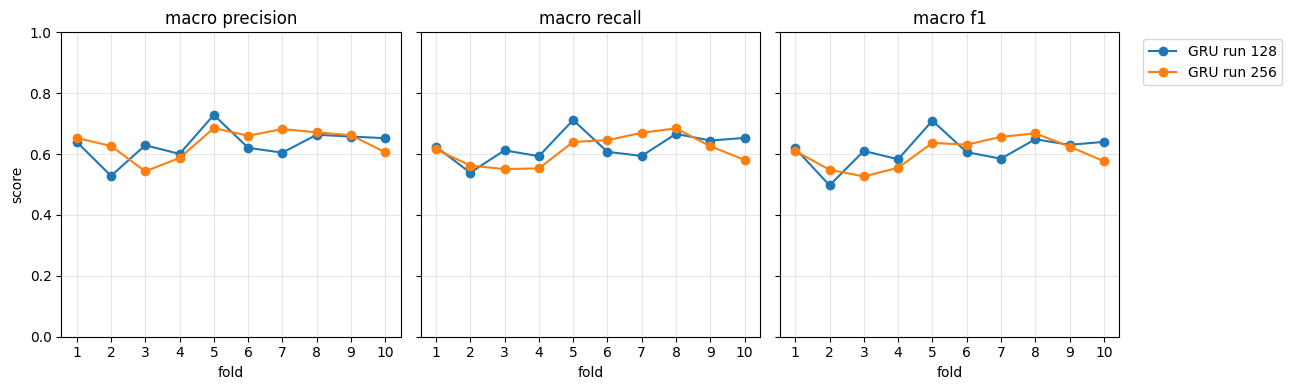

In [2]:
from pathlib import Path
import json, pandas as pd, matplotlib.pyplot as plt

friendly_names = {
    "cv_rnn_20251123-131624": "GRU run 128",
    "cv_rnn_20251124-160637": "GRU run 256",
}

def display_name(run):
    return friendly_names.get(run, run)

def load_macro_per_fold(run_dir):
    rows = []
    for fold_json in sorted(run_dir.glob("fold*_metrics.json")):
        fold = int(fold_json.stem.split('_')[0].replace('fold', ''))
        with open(fold_json) as f:
            data = json.load(f)
        macro = data.get("classification_report", {}).get("macro avg", {})
        if macro:
            rows.append({
                "run": run_dir.name,
                "label": display_name(run_dir.name),
                "fold": fold,
                "precision": macro.get("precision"),
                "recall": macro.get("recall"),
                "f1": macro.get("f1-score"),
            })
    return rows

rows = []
for run_dir in sorted(Path("runs").glob("cv_rnn_*")):
    rows.extend(load_macro_per_fold(run_dir))

per_fold_df = pd.DataFrame(rows).sort_values(["label", "fold"])

if per_fold_df.empty:
    print("Sem métricas macro para cv_rnn_*")
else:
    fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
    metrics = ["precision", "recall", "f1"]
    xticks = sorted(per_fold_df["fold"].unique())
    for ax, metric in zip(axes, metrics):
        for label, subset in per_fold_df.groupby("label"):
            ax.plot(subset["fold"], subset[metric], marker="o", label=label)
        ax.set_title(f"macro {metric}")
        ax.set_xlabel("fold")
        ax.set_xticks(xticks)
        ax.set_ylim(0, 1)
        ax.grid(alpha=0.3)
    axes[0].set_ylabel("score")
    axes[-1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


#### Accuracy média e desvio-padrão (summary.json) — RNN
Barras com `acc_mean` e `acc_std` para cada run `cv_rnn_*`.


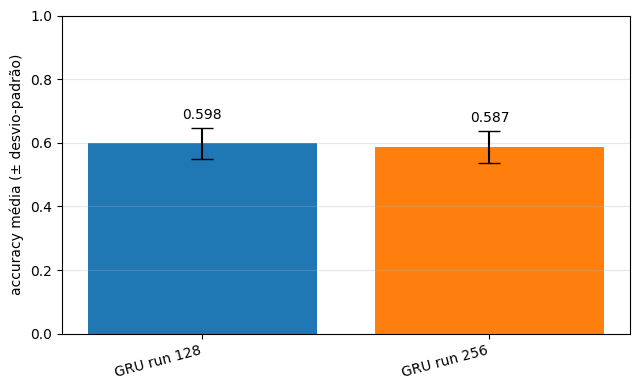

,run,label,acc_mean,acc_std
0,cv_rnn_20251123-131624,GRU run 128,0.598160,0.048844
1,cv_rnn_20251124-160637,GRU run 256,0.586836,0.051730


In [4]:
import json
from pathlib import Path
import pandas as pd, matplotlib.pyplot as plt

friendly_names = {
    "cv_rnn_20251123-131624": "GRU run 128",
    "cv_rnn_20251124-160637": "GRU run 256",
}

def display_name(run):
    return friendly_names.get(run, run)

summary_rows = []
for summary_path in sorted(Path("runs").glob("cv_rnn_*/summary.json")):
    with open(summary_path) as f:
        data = json.load(f)
    run = summary_path.parent.name
    summary_rows.append({
        "run": run,
        "label": display_name(run),
        "acc_mean": data.get("acc_mean"),
        "acc_std": data.get("acc_std"),
    })

summary_df = pd.DataFrame(summary_rows).sort_values("acc_mean", ascending=False)
if summary_df.empty:
    print("Sem summary.json para cv_rnn_*")
else:
    fig, ax = plt.subplots(figsize=(6.5, 4))
    colors = list(plt.cm.tab10.colors)
    bars = ax.bar(
        summary_df["label"],
        summary_df["acc_mean"],
        yerr=summary_df["acc_std"],
        capsize=8,
        color=colors[: len(summary_df)],
    )
    ax.set_ylabel("accuracy média (± desvio-padrão)")
    ax.set_ylim(0, 1)
    ax.grid(axis="y", alpha=0.3)
    ax.bar_label(bars, fmt="{:.3f}", padding=4)
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right")
    plt.tight_layout()
    plt.show()

summary_df


#### Matrizes de confusão (10 folds cumulativas) — RNN
Imagens agregadas dos 10 folds para cada run `cv_rnn_*`.


GRU run 128


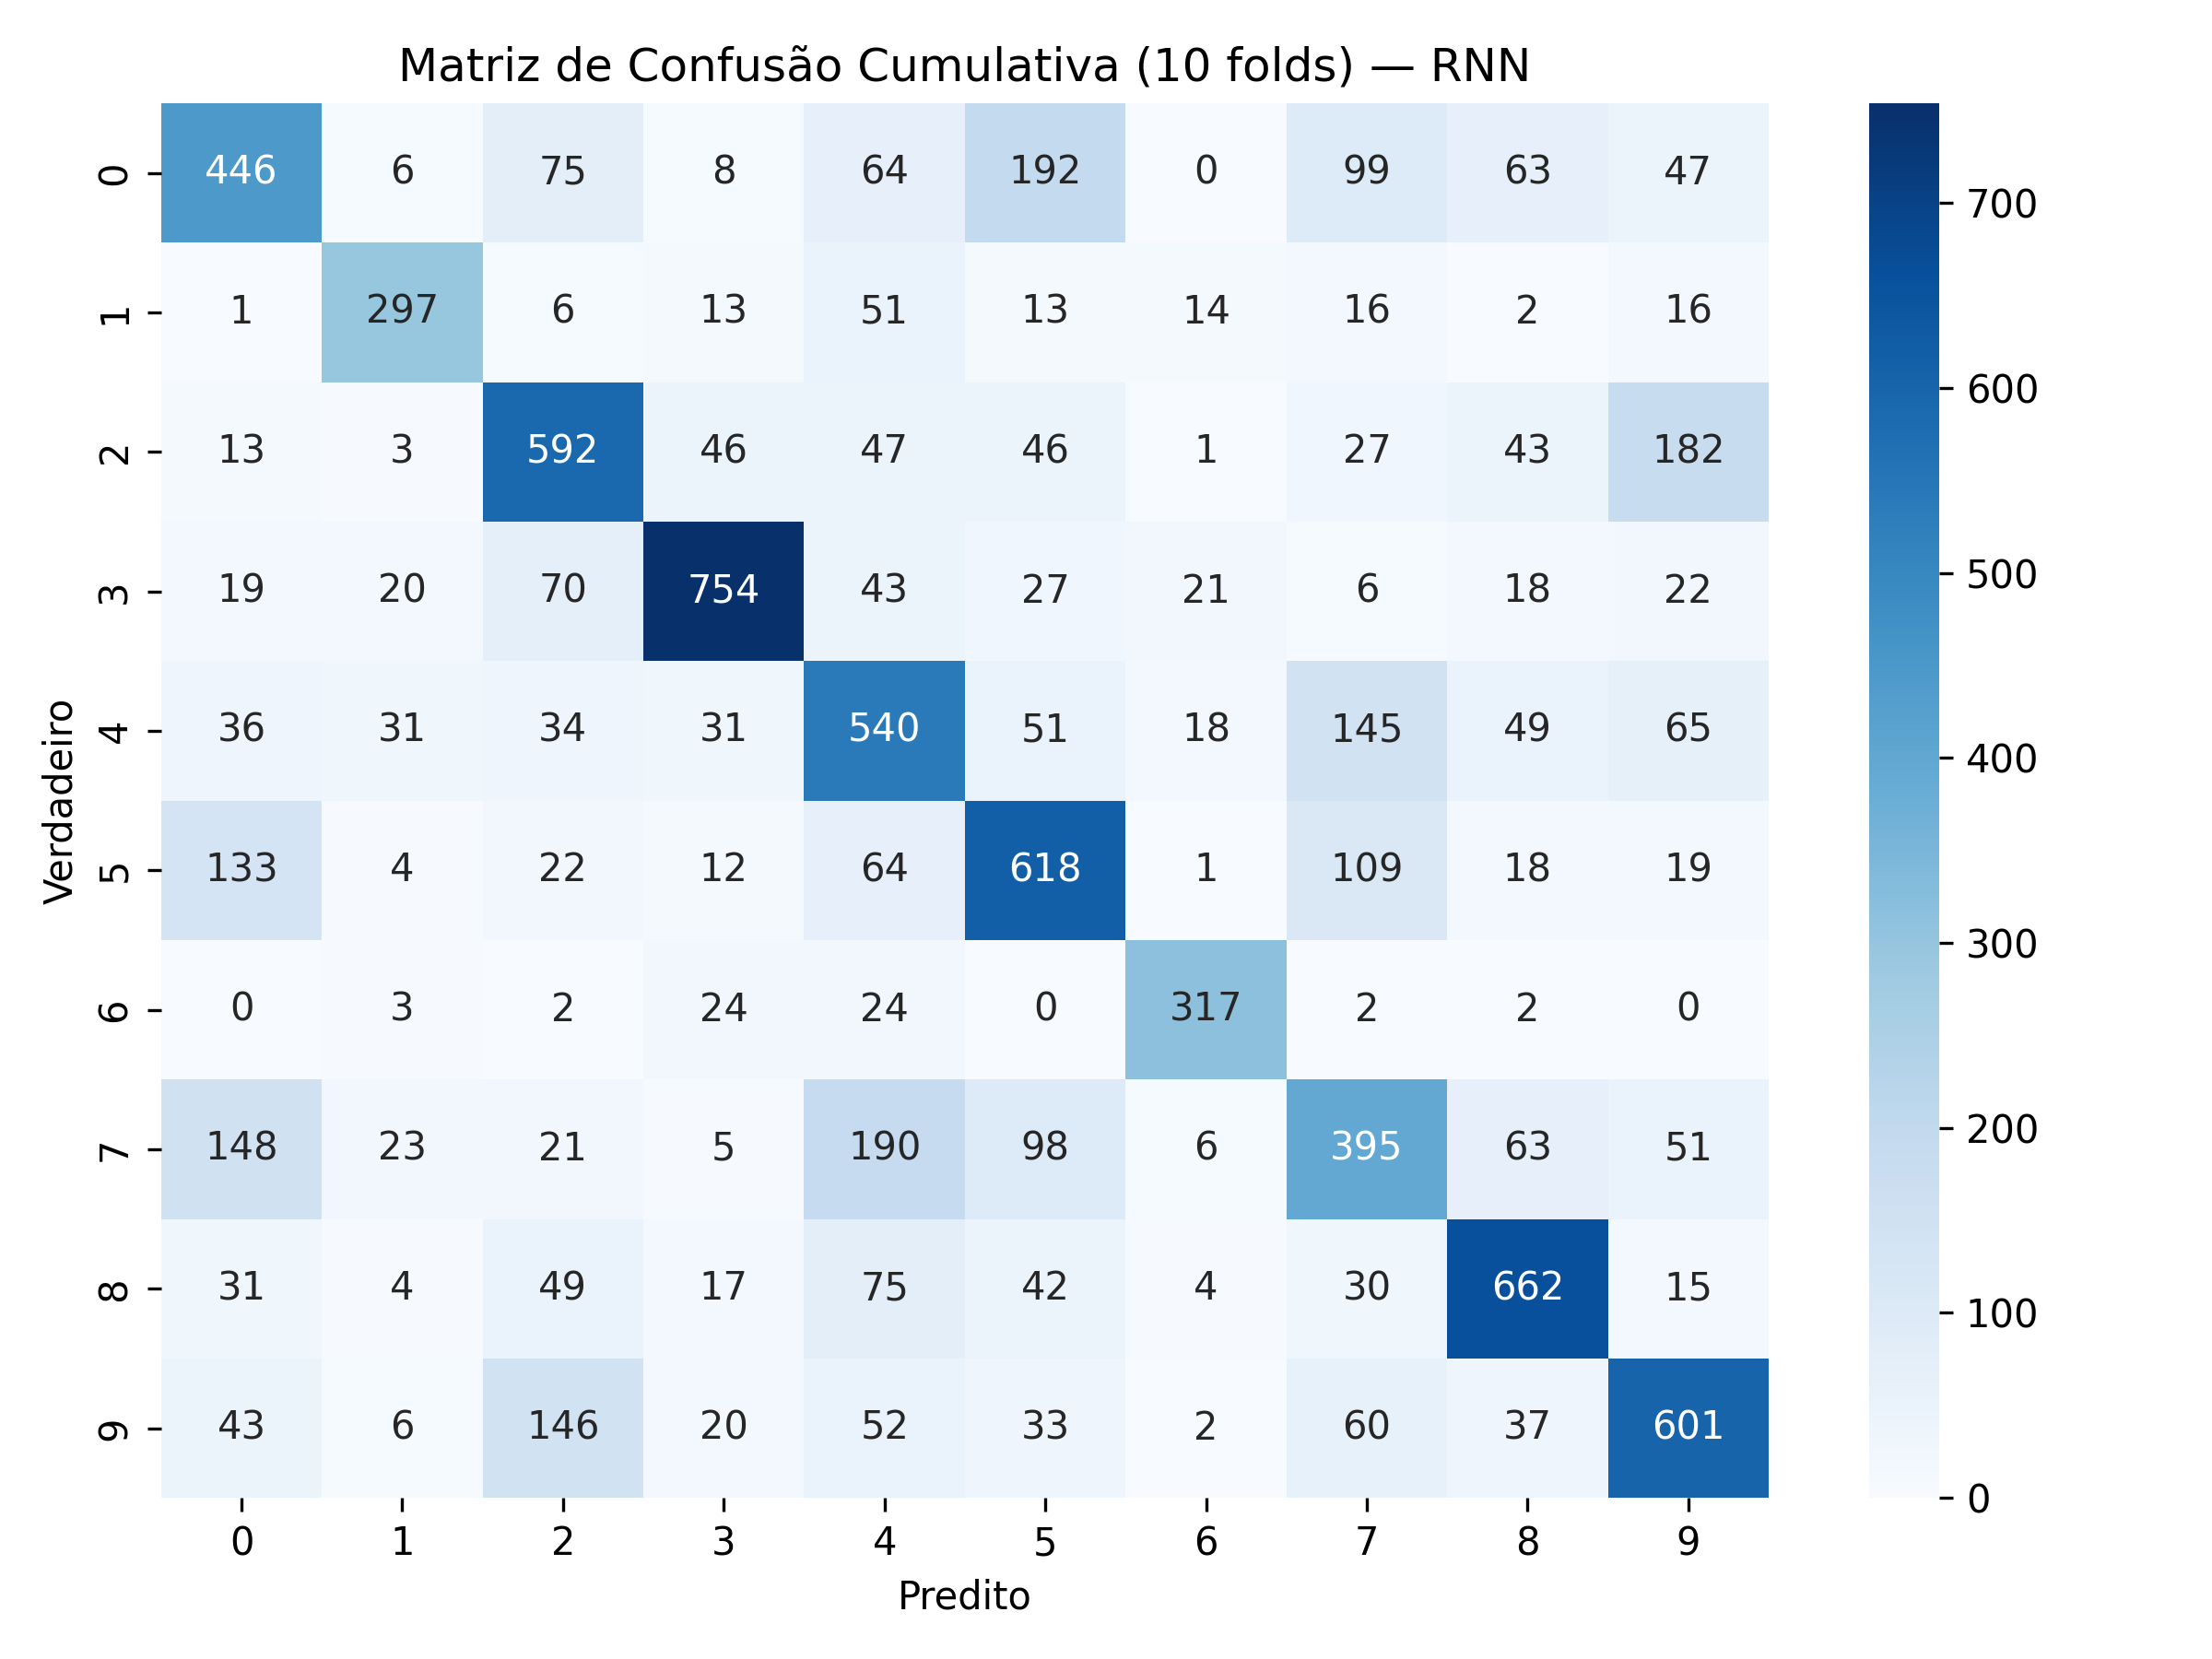

GRU run 256


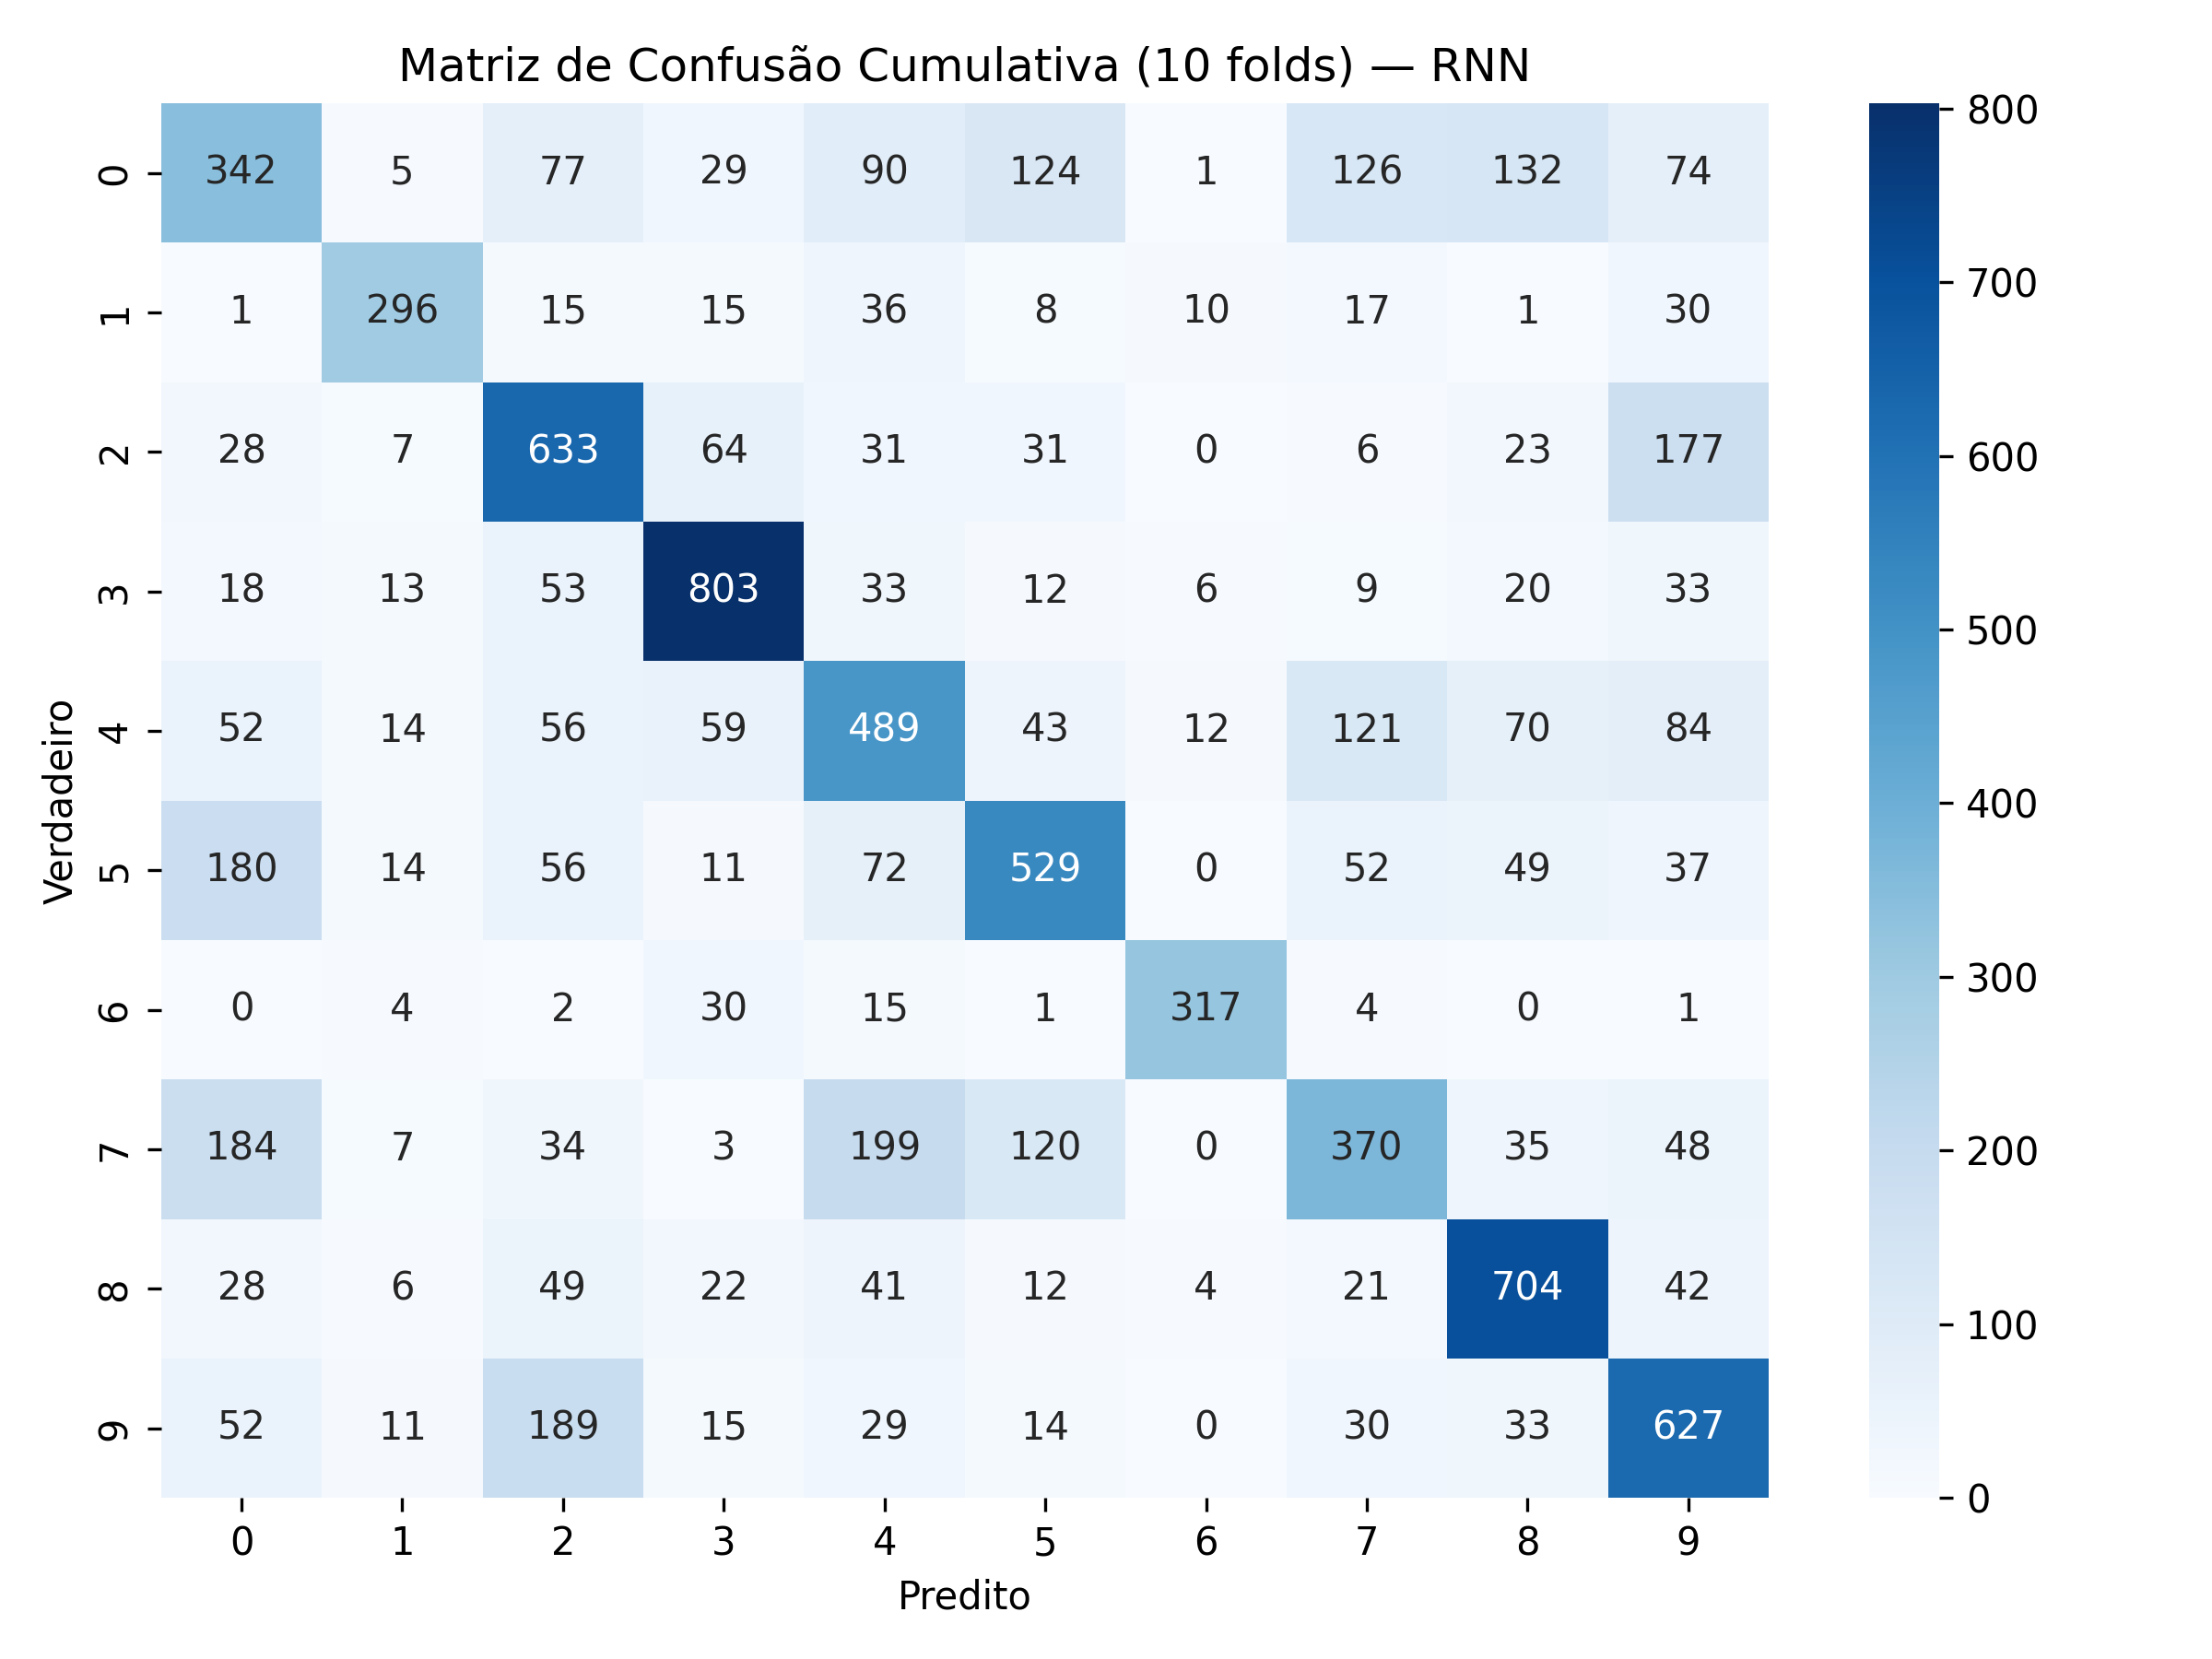

In [6]:
from pathlib import Path
from IPython.display import display, Image

friendly_names = {
    "cv_rnn_20251123-131624": "GRU run 128",
    "cv_rnn_20251124-160637": "GRU run 256",
}

def display_name(run):
    return friendly_names.get(run, run)

cm_paths = sorted(Path("runs").glob("cv_rnn_*/confusion_matrix_cumulative.png"))
if not cm_paths:
    print("Sem matrizes de confusão para cv_rnn_*")
else:
    for cm_path in cm_paths:
        label = display_name(cm_path.parent.name)
        print(label)
        display(Image(filename=str(cm_path), width=520))


### 5.4 Análise por classe: CNN vs RNN (10 folds)

Comparação de acerto por classe (recall macro por classe) usando as matrizes de confusão acumuladas dos 10 folds (`confusion_matrix_cumulative.csv`), destacando onde cada modelo acerta mais e onde mais se confunde.


In [11]:
from pathlib import Path
import numpy as np, pandas as pd

friendly_names = {
    "cv_cnn_20251030-102146": "CNN baseline",
    "cv_cnn_20251122-224117": "CNN tuned",
    "cv_rnn_20251123-131624": "GRU run 128",
    "cv_rnn_20251124-160637": "GRU run 256",
}

def display_name(run):
    return friendly_names.get(run, run)

def load_class_labels():
    try:
        return (meta[["classID", "class"]]
                .drop_duplicates()
                .sort_values("classID")
                ["class"]
                .tolist())
    except Exception:
        return None

def per_class_recall(cm):
    row_sums = cm.sum(axis=1)
    return np.divide(np.diag(cm), row_sums, out=np.zeros_like(row_sums, dtype=float), where=row_sums>0)

def top_confusions(cm, top=3):
    cm_off = cm.copy()
    np.fill_diagonal(cm_off, 0)
    pairs = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm_off[i, j] > 0:
                pairs.append((cm_off[i, j], i, j))
    pairs.sort(reverse=True)
    return pairs[:top]

records = []
confusion_summaries = {}
labels = None

for cm_path in sorted(Path("runs").glob("cv_*_*/confusion_matrix_cumulative.csv")):
    run = cm_path.parent.name
    if not (run.startswith("cv_cnn") or run.startswith("cv_rnn")):
        continue
    cm = np.loadtxt(cm_path, delimiter=",", dtype=int)
    if labels is None:
        labels = load_class_labels()
    if labels is None or len(labels) != cm.shape[0]:
        labels = [f"classe {i}" for i in range(cm.shape[0])]
    recall = per_class_recall(cm)
    for idx, r in enumerate(recall):
        records.append({
            "run": display_name(run),
            "class": labels[idx],
            "recall": r
        })
    confusion_summaries[display_name(run)] = top_confusions(cm, top=3)

recall_df = pd.DataFrame(records)
if recall_df.empty:
    print("Sem matrizes de confusão para cv_cnn_*/cv_rnn_*")
else:
    pivot = recall_df.pivot(index="class", columns="run", values="recall").sort_index()
    display(pivot.style.format("{:.3f}"))

    for run in pivot.columns:
        series = pivot[run].dropna()
        best = series.sort_values(ascending=False).head(2)
        worst = series.sort_values().head(2)
        print(f"Resumo {run}:")
        print("  Melhores classes (recall):")
        for cls, val in best.items():
            print(f"   - {cls}: {val:.3f}")
        print("  Piores classes (recall):")
        for cls, val in worst.items():
            print(f"   - {cls}: {val:.3f}")
        confs = confusion_summaries.get(run, [])
        if confs:
            print("  Maiores confusões (origem → predito):")
            for count, i, j in confs:
                print(f"   - {labels[i]} → {labels[j]} ({count} exemplos)")
        else:
            print("  Sem confusões registadas.")


run,CNN baseline,CNN tuned,GRU run 128,GRU run 256
class,,,,
classe 0,0.443,0.383,0.446,0.342
classe 1,0.597,0.557,0.692,0.690
classe 2,0.696,0.719,0.592,0.633
classe 3,0.679,0.673,0.754,0.803
classe 4,0.625,0.554,0.540,0.489
classe 5,0.522,0.520,0.618,0.529
classe 6,0.904,0.848,0.848,0.848
classe 7,0.683,0.547,0.395,0.370
classe 8,0.620,0.614,0.713,0.758


Resumo CNN baseline:
  Melhores classes (recall):
   - classe 6: 0.904
   - classe 9: 0.735
  Piores classes (recall):
   - classe 0: 0.443
   - classe 5: 0.522
  Maiores confusões (origem → predito):
   - classe 5 → classe 0 (197 exemplos)
   - classe 0 → classe 5 (151 exemplos)
   - classe 4 → classe 7 (140 exemplos)
Resumo CNN tuned:
  Melhores classes (recall):
   - classe 6: 0.848
   - classe 2: 0.719
  Piores classes (recall):
   - classe 0: 0.383
   - classe 5: 0.520
  Maiores confusões (origem → predito):
   - classe 0 → classe 5 (223 exemplos)
   - classe 5 → classe 7 (214 exemplos)
   - classe 7 → classe 0 (172 exemplos)
Resumo GRU run 128:
  Melhores classes (recall):
   - classe 6: 0.848
   - classe 3: 0.754
  Piores classes (recall):
   - classe 7: 0.395
   - classe 0: 0.446
  Maiores confusões (origem → predito):
   - classe 0 → classe 5 (192 exemplos)
   - classe 7 → classe 4 (190 exemplos)
   - classe 2 → classe 9 (182 exemplos)
Resumo GRU run 256:
  Melhores classes (r

#### Visualização gráfica por classe (recall) — CNN vs RNN
Barras agrupadas por classe comparando o recall (10 folds cumulativos) de todas as runs `cv_cnn_*` e `cv_rnn_*`


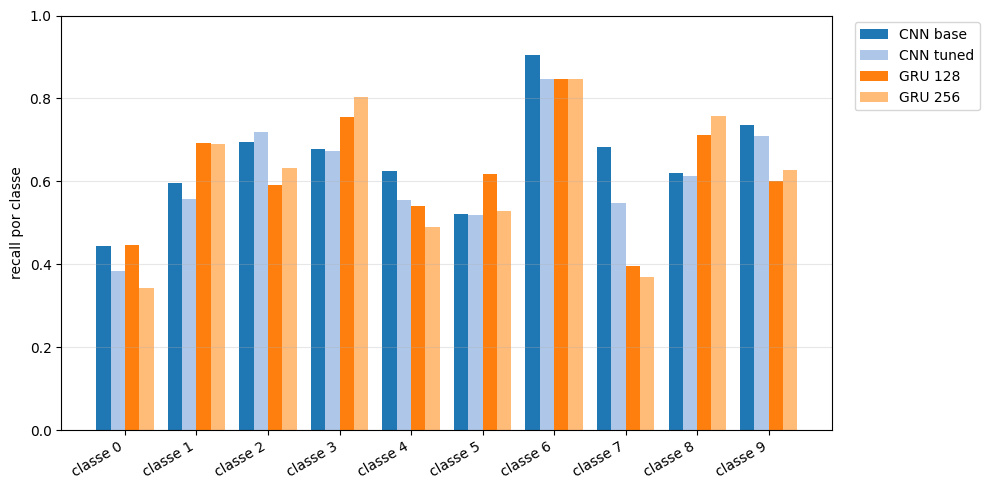

In [14]:
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

friendly_names = {
    'cv_cnn_20251030-102146': 'CNN base',
    'cv_cnn_20251122-224117': 'CNN tuned',
    'cv_rnn_20251123-131624': 'GRU 128',
    'cv_rnn_20251124-160637': 'GRU 256',
}

def display_name(run):
    return friendly_names.get(run, run)

def load_class_labels():
    try:
        return (meta[['classID','class']].drop_duplicates().sort_values('classID')['class'].tolist())
    except Exception:
        return None

def per_class_recall(cm):
    row_sums = cm.sum(axis=1)
    return np.divide(np.diag(cm), row_sums, out=np.zeros_like(row_sums, dtype=float), where=row_sums>0)

records = []
labels = None
for cm_path in sorted(Path('runs').glob('cv_*_*/confusion_matrix_cumulative.csv')):
    run = cm_path.parent.name
    if not (run.startswith('cv_cnn') or run.startswith('cv_rnn')):
        continue
    cm = np.loadtxt(cm_path, delimiter=',', dtype=int)
    if labels is None:
        labels = load_class_labels()
    if labels is None or len(labels) != cm.shape[0]:
        labels = [f'classe {i}' for i in range(cm.shape[0])]
    recall = per_class_recall(cm)
    for idx, r in enumerate(recall):
        records.append({'class': labels[idx], 'run': display_name(run), 'recall': r})

df = pd.DataFrame(records)
if df.empty:
    print('Sem dados para plotar')
else:
    pivot = df.pivot(index='class', columns='run', values='recall').sort_index()
    runs = list(pivot.columns)
    x = np.arange(len(pivot.index))
    width = 0.8 / max(len(runs), 1)
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = list(plt.cm.tab20.colors)
    for i, run in enumerate(runs):
        ax.bar(x + i*width, pivot[run], width, label=run, color=colors[i % len(colors)])
    ax.set_xticks(x + width*(len(runs)-1)/2)
    ax.set_xticklabels(pivot.index, rotation=30, ha='right')
    ax.set_ylabel('recall por classe')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



### 5.5 Conclusão do Modelo 2 (RNN)

A arquitetura recorrente (GRU) atingiu **≈ 59.8% de accuracy** no teste do fold1 (melhor validação ≈ 61.2%). O desempenho é **inferior ao da CNN (~63.8%)**, o que sugere que, neste problema, **a extração de padrões tempo-frequência locais via convoluções 2D** é mais determinante do que modelar a sequência temporal isoladamente.

Observámos bom comportamento em classes com **eventos impulsivos/ritmados** (ex.: *jackhammer*, *car_horn*), enquanto **sons contínuos** (ex.: *air_conditioner*, *engine_idling*, *drilling*) foram mais difíceis. Estas classes partilham **texturas espectrais estáveis**, que a RNN, sem uma etapa convolucional prévia, não separa tão bem.

Este modelo cumpre o papel de **baseline sequencial** e reforça a conclusão de que arquiteturas **convolucionais ou híbridas (CRNN: CNN→RNN)** tendem a ser mais adequadas ao UrbanSound8K. Melhorias futuras incluem: aumentar `hidden/layers`, reforçar *dropout/early stopping*, e testar **combinações CNN+GRU** para explorar simultaneamente **padrões espaciais e temporais**.


### Optuna: melhores trials (ordenado por value)

Carrega os CSVs gerados pelo Optuna (cnn/rnn se existirem) e lista os trials ordenados pelo `value` (acc).


In [12]:
from pathlib import Path
import pandas as pd

paths = [Path('runs/optuna_results_cnn.csv'), Path('runs/optuna_results_rnn.csv')]
dfs = []
for p in paths:
    if p.exists():
        df = pd.read_csv(p)
        df['source'] = p.stem
        dfs.append(df)

if not dfs:
    raise FileNotFoundError('Nenhum CSV de optuna encontrado em runs/')

optuna_df = pd.concat(dfs, ignore_index=True)



# Melhor trial por modelo se a coluna existir
if 'model' in optuna_df.columns:
    display(optuna_df.sort_values('value', ascending=False).drop_duplicates('model'))


,study,model,started_at,epochs,trial,state,value,batch,lr,dropout,source
30,us8k_optuna,cnn,2025-11-22T17:12:51,12,17,COMPLETE,0.726404,16,0.000660,0.288747,optuna_results_cnn
71,us8k_optuna,rnn,2025-11-23T08:25:36,12,18,COMPLETE,0.665472,16,0.001292,0.147117,optuna_results_rnn
